In [1]:
import os 
import json
import pandas as pd
import numpy as np
from utils import view_histo_from_massaged, do_pca, do_tsne

CONFIDENCE = 0.95 # Probalility threshold
target_dir = "ann_training95" # location where intermediate training sets, models, dataframes are stored

In [2]:
meta = {
    "dset_path": "/home/mantydze/data/ZeroBias2017B/massaged/chargeInner_PXLayer_1.csv",
    "dset_name": "ZeroBias",
    "dset_era": "2017B",
    "histo_name": "chargeInner_PXLayer_1",
    
    "good": [{"run_number": 297050, "exclude": [420, 421, 424, 426, 429]}, 
             {"run_number": 297056, "exclude": [31, 34, 36, 40]}, 
             {"run_number": 297178, "exclude": [675, 678, 680, 683, 1266, 1378]}, 
             {"run_number": 297359, "include": [39, 43, 45, 180]},
             {"run_number": 297675, "exclude": [242]}
            ],
    "bad": [{"run_number": 297047}, {"run_number": 297048}, 
            {"run_number": 297170}, {"run_number": 297171}, 
            {"run_number": 297281}, {"run_number": 297284}, 
            {"run_number": 297286}, {"run_number": 297664}, 
            {"run_number": 297671}, {"run_number": 297672}, 
            {"run_number": 297050, "include": [420, 421, 424, 426, 429]}, 
            {"run_number": 297056, "include": [31, 34, 36, 40]}, 
            {"run_number": 297178, "include": [675, 678, 680, 683, 1266, 1378]}]
}

# Train and test data

In [3]:
# Train data
df_train = pd.read_csv("train.csv")
df_train.shape

(3070, 117)

In [4]:
# Test data
df_test = pd.read_csv("test.csv")
df_test.shape

(24122, 116)

In [5]:
# Filter list of columns which will be used for training
bin_cols = [col for col in df_train.columns if 'bin_' in col]

# remove first and last values as those are over/under flows
bin_cols = bin_cols[1:-1]

Explained variance ratio [0.88459841 0.10468089 0.00259086 0.00215053]


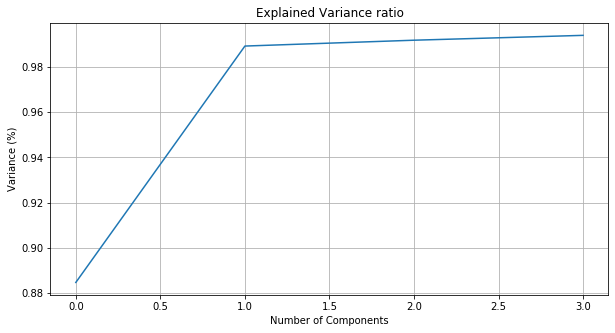

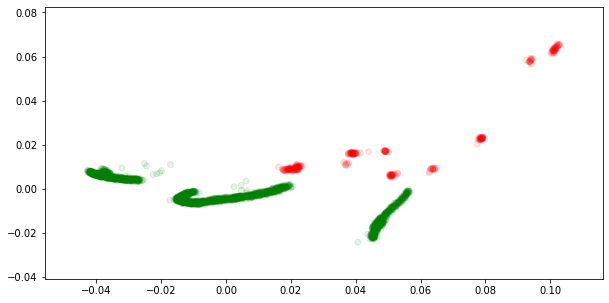

In [6]:
do_pca(df_train)

# ANN training

In [7]:
from tensorflow import keras
from tensorflow.keras import layers

def create_model():
    model = keras.Sequential()
    model.add(layers.Dense(units=50, activation="relu", input_shape=(100,)))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=25, activation="relu"))
    model.add(layers.Dropout(0.2))
    model.add(layers.Dense(units=1, activation="sigmoid"))
    model.compile(optimizer="adam", loss="binary_crossentropy", metrics=["accuracy"])
    
    return model

In [8]:
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

def train_model(df):    
    print("Training model")
    
    # Normalization, divide every bin value by total entries
    X = df.filter(bin_cols, axis=1).copy().div(df.entries, axis=0)
    y = df["y"]
    
    # Stratified shuffle split
    X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25)
    
    X_train = np.asarray(X_train)
    X_test = np.asarray(X_test)
    
    
    y_train = np.asarray(y_train)
    y_test = np.asarray(y_test)
    
    model = create_model()
    
    # Train
    es = EarlyStopping(monitor='loss', mode='min', patience=5, verbose=1)
    model.fit(X_train, y_train, verbose=0, 
              batch_size=150, 
              epochs=1000, 
              shuffle=True,
              callbacks=[es])
    
    # Predict
    y_pred_ = model.predict(X_test)
    y_pred = (y_pred_ > 0.5)
    
    # Validate model    
    print("Accuracy", round(accuracy_score(y_test, y_pred), 3))
    print(confusion_matrix(y_test, y_pred))    
   
    return model

In [9]:
import matplotlib.pyplot as plt

def view_lumisections(df, label, limit=3):
    
    rows, cols = divmod(limit, 3) # three plots per row
    if cols > 0:
        rows+=1
    
    fig = plt.figure(figsize=(15, rows*3))
    fig.subplots_adjust(hspace=0.4, wspace=0.4)
       
    i = 1
    for index, row in df[df['y']==label].iterrows():
        
        data = [row[col] for col in row.keys() if 'bin_' in col]
        
        # remove first and last values as those are over/under flows
        data = data[1:-1]
        
        hname = row["hname"]
        run_number = row["run"]
        ls_number = row["lumi"]
        is_good = row["good"]
        y = row["ybins"]
        x = row["xbins"]
        y_pred = row["y_pred"]
        
        ax = plt.subplot(rows, 3, i)
        
        ax.set_title("run %d, ls: %s, y_pred: %.2f" % (run_number, ls_number, y_pred))        
        ax.plot(range(len(data)), data, drawstyle='steps-pre', label=hname)
                
        i = i + 1        
        if i > limit:        
            break            
            
    if i > 1:
        plt.show()
    else:
        plt.close()

In [10]:
df_anomalies = None

def self_train(df_train, df_test, run_numbers):
    
    model = train_model(df_train)
    
    print(df_train.shape)
    
    for index, run_number in enumerate(run_numbers):
        
        print()
        print("*"*80)
        print("Classifying Run {}\n".format(run_number))
        
        # Classify new run
       
        # Dataset of a single run
        df_run = df_test[df_test["run"] == run_number].copy()
    
        if len(df_run) == 0:
            print("Run {} has no data in test dataset".format(run_number))
            continue

        # Scale each row by dividing by number of total entries within a run
        X = df_run.filter(bin_cols, axis=1).div(df_run.entries, axis=0)
        X = np.asarray(X)
        
        y_pred = model.predict(X)

        # Prediction value by ANN
        df_run["y_pred"] = y_pred
        
        # Predictions with higher probability than threshold are considered as GOOD
        df_run['y_good'] = (y_pred >= CONFIDENCE)
        # Predictions with lower probability than threshold are considered as BAD
        df_run['y_bad'] = (y_pred <= 1-CONFIDENCE)
        # Predictions between lower and higher thresholds are considered as ANOMALIES
        df_run['y_anom'] = (1-CONFIDENCE < y_pred) & (y_pred < CONFIDENCE)
        
        # Create new column y and set final label there
        df_run.loc[df_run['y_good'] == 1, 'y'] = 1
        df_run.loc[df_run['y_bad'] == 1, 'y'] = 0
        df_run.loc[df_run['y_anom'] == 1, 'y'] = 2
        df_run = df_run.astype({"y":"int32"})
        
        # Preview distribution of a single run data
        try:
            do_pca(df_run, include_elbow=False, title="Run {}".format(run_number))
        except Exception as e:
            print(e)
            print("failed to do pca for run {}".format(run_number))
        
        # Preview a subset of classified lumisections
        bad_ls = df_run[df_run['y']==0]["lumi"].tolist()
        good_ls = df_run[df_run['y']==1]["lumi"].tolist()
        anom_ls = df_run[df_run['y']==2]["lumi"].tolist()
        
        print("Good LS:", len(good_ls), sorted(good_ls))
        print("Bad LS:", len(bad_ls), sorted(bad_ls))
        print("Anomalies LS:", len(anom_ls), sorted(anom_ls))
        
        print("GOOD LS")
        view_lumisections(df_run, 1, 4)
        print("BAD LS")
        view_lumisections(df_run, 0, 6)
        print("ANOMALOUS LS")
        view_lumisections(df_run, 2, 6)
        
        # Take a subset of only anomalies (y=2)
        new_anomalies = df_run[df_run["y"]==2].copy()        
        global df_anomalies        
        if df_anomalies is None:
            df_anomalies = new_anomalies
        else:
            df_anomalies = pd.concat([df_anomalies, new_anomalies], ignore_index=True, sort=False)    
            
            
        # Take a subset of only good and bad predictions, but no anomalies
        df_confident = df_run[df_run["y"]<=1].copy()
        
        # Add new predictions to a training dataset
        df_train = pd.concat([df_train, df_confident], ignore_index=True, sort=False)
        
        
        print("Training set shape", df_train.shape)
        
        try:
            do_pca(pd.concat([df_anomalies, df_train], ignore_index=True, sort=False), 
                   include_elbow=False, title="Training set {}".format(index), 
                   save_path="{}/{}.png".format(target_dir, index))
        except Exception as e:
            print(e)
            print("failed to do pca for run {}".format(run_number))
        
        # Retrain model with extended dataset
        model = train_model(df_train)
    
    return model, df_train

In [11]:
run_numbers = sorted(list(df_test["run"].unique()))
# run_numbers = run_numbers[:10]
print(run_numbers)


[297049, 297057, 297099, 297100, 297101, 297113, 297114, 297168, 297169, 297175, 297176, 297177, 297179, 297180, 297181, 297211, 297215, 297218, 297219, 297224, 297225, 297227, 297282, 297283, 297285, 297287, 297288, 297289, 297290, 297291, 297292, 297293, 297296, 297308, 297359, 297411, 297424, 297425, 297426, 297429, 297430, 297431, 297432, 297433, 297434, 297435, 297467, 297468, 297469, 297474, 297483, 297484, 297485, 297486, 297487, 297488, 297494, 297495, 297496, 297497, 297498, 297499, 297501, 297502, 297503, 297504, 297505, 297557, 297558, 297562, 297563, 297598, 297599, 297603, 297604, 297605, 297606, 297620, 297656, 297657, 297658, 297659, 297660, 297661, 297662, 297663, 297665, 297666, 297670, 297673, 297674, 297678, 297722, 297723, 298653, 298678, 298996, 298997, 298998, 299000, 299042, 299061, 299062, 299064, 299065, 299067, 299096, 299149, 299178, 299180, 299183, 299184, 299185, 299316, 299317, 299318, 299324, 299325, 299326, 299327, 299329]


### Train ANN

Training model
Epoch 00137: early stopping
Accuracy 1.0
[[ 71   0]
 [  0 697]]
(3070, 117)

********************************************************************************
Classifying Run 297049

Explained variance ratio [0.14436087 0.14033191 0.12865562 0.11408609]


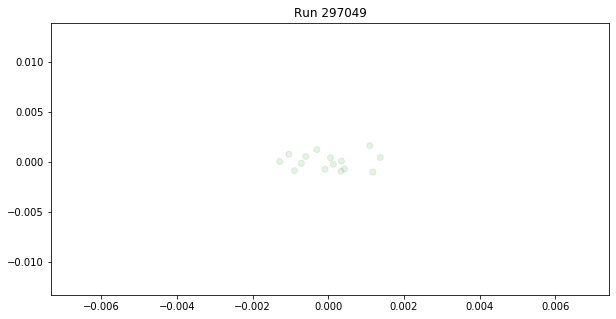

Good LS: 15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


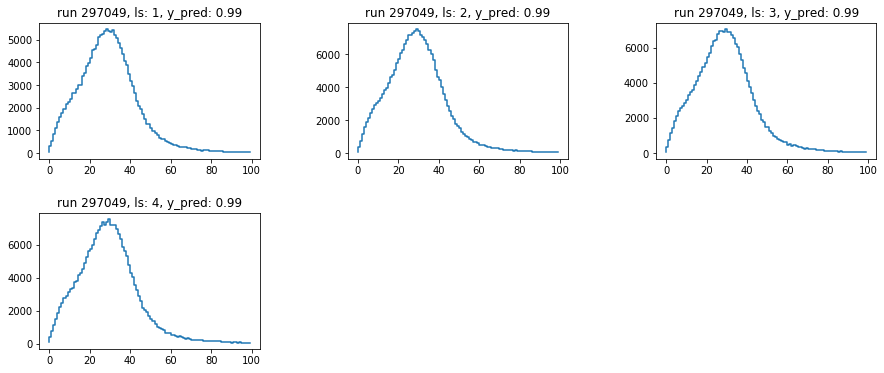

BAD LS
ANOMALOUS LS
Training set shape (3085, 121)
Explained variance ratio [0.88457218 0.10467569 0.00260641 0.00215079]


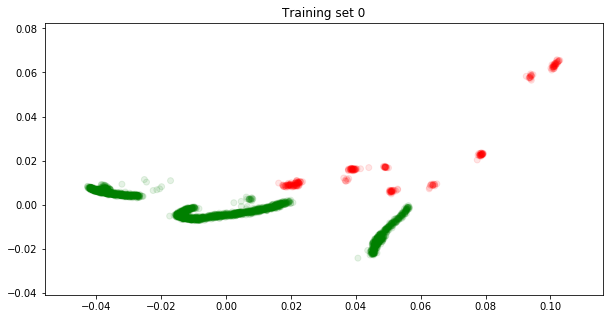

Training model
Epoch 00126: early stopping
Accuracy 1.0
[[ 71   0]
 [  0 701]]

********************************************************************************
Classifying Run 297057

Explained variance ratio [0.89894577 0.0448453  0.01241251 0.00238898]


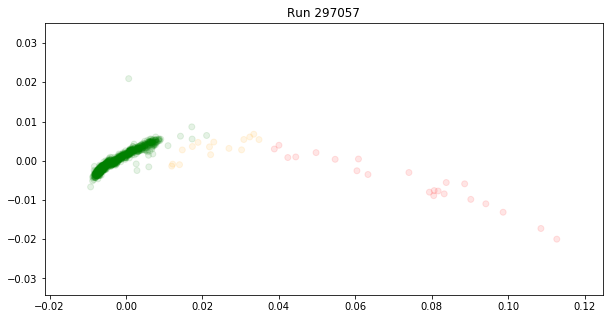

Good LS: 870 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 199, 204, 205, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226,

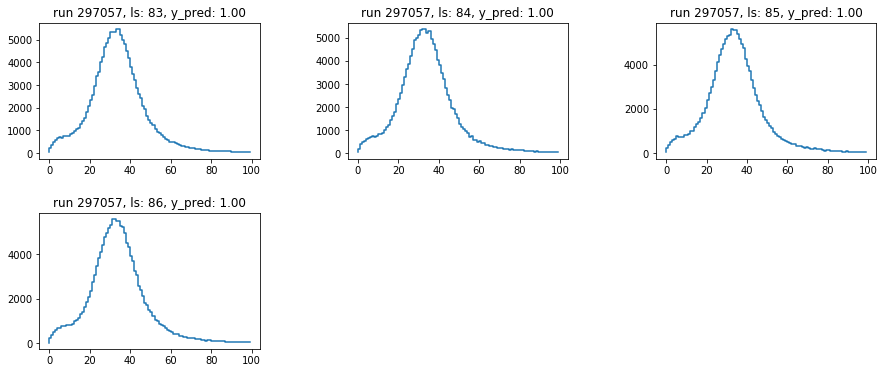

BAD LS


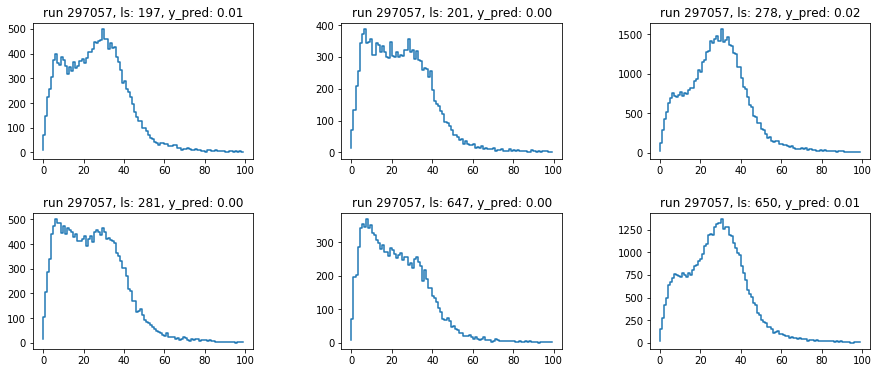

ANOMALOUS LS


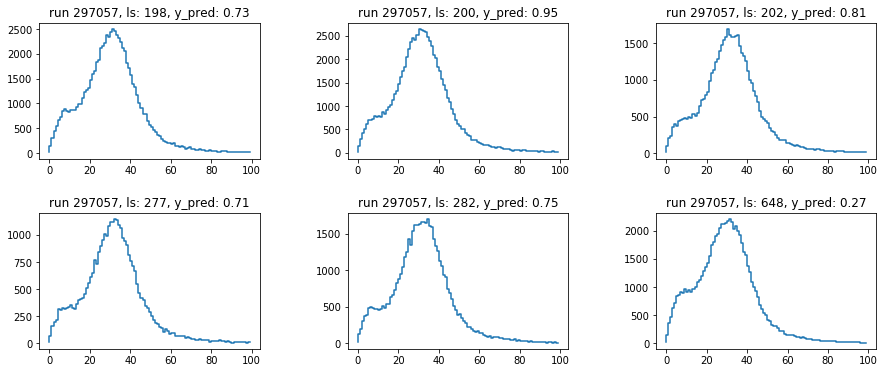

Training set shape (3977, 121)
Explained variance ratio [0.89266405 0.09582879 0.0024845  0.00196472]


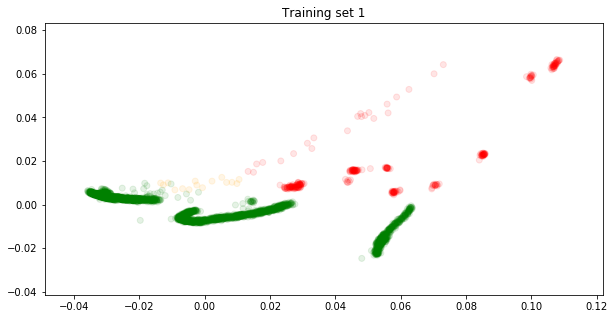

Training model
Epoch 00119: early stopping
Accuracy 1.0
[[ 76   0]
 [  0 919]]

********************************************************************************
Classifying Run 297099

Explained variance ratio [0.82535404 0.06858427 0.02886628 0.01011672]


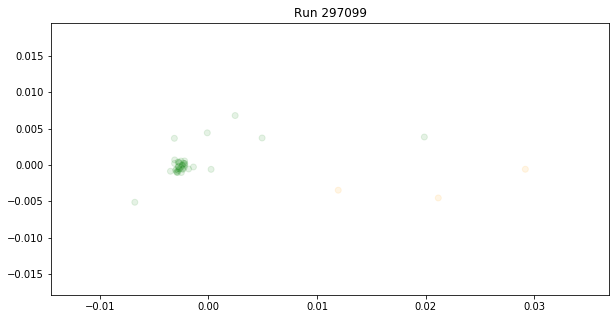

Good LS: 38 [20, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62]
Bad LS: 0 []
Anomalies LS: 3 [31, 32, 36]
GOOD LS


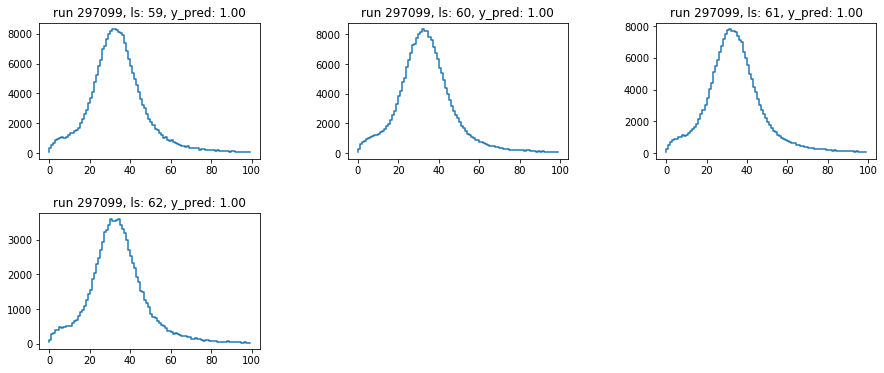

BAD LS
ANOMALOUS LS


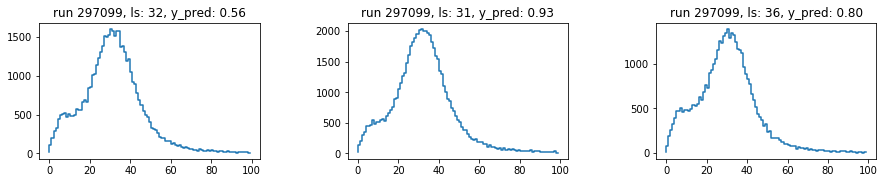

Training set shape (4015, 121)
Explained variance ratio [0.8931485  0.09527493 0.00249523 0.00196505]


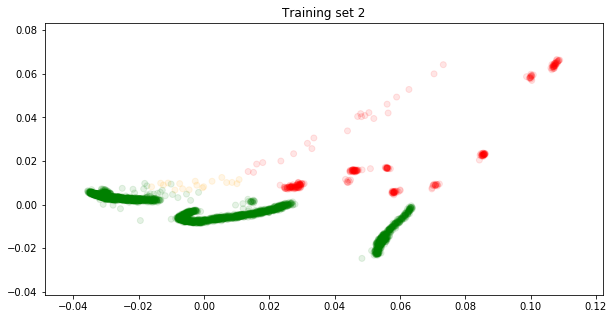

Training model
Epoch 00150: early stopping
Accuracy 1.0
[[ 76   0]
 [  0 928]]

********************************************************************************
Classifying Run 297100

Explained variance ratio [0.35384556 0.25251687 0.09188728 0.06362276]


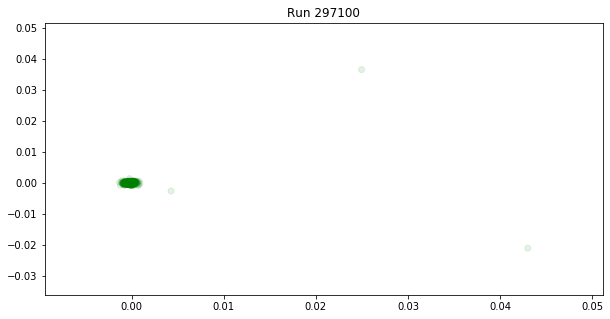

Good LS: 376 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

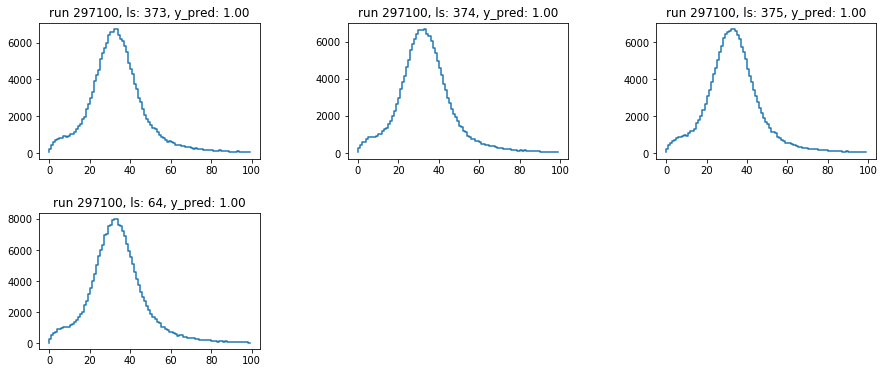

BAD LS
ANOMALOUS LS
Training set shape (4391, 121)
Explained variance ratio [0.89794053 0.08977892 0.00240074 0.00189942]


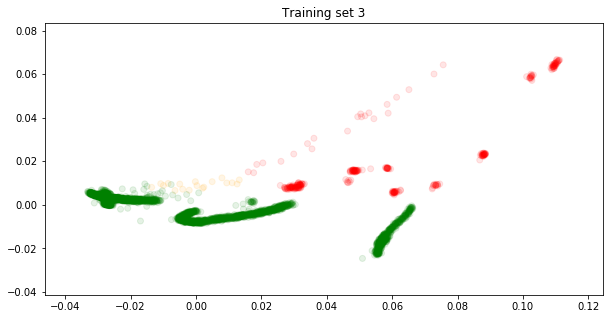

Training model
Epoch 00161: early stopping
Accuracy 1.0
[[  76    0]
 [   0 1022]]

********************************************************************************
Classifying Run 297101

Explained variance ratio [0.82395161 0.08475625 0.00396142 0.0038774 ]


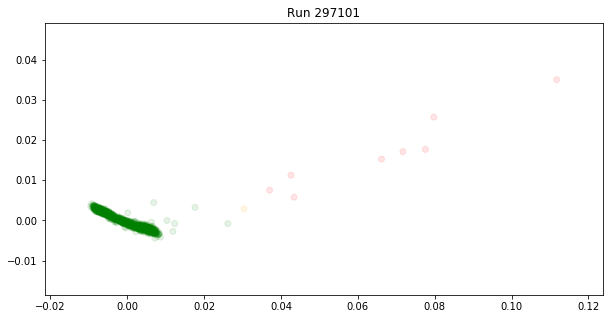

Good LS: 1093 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219

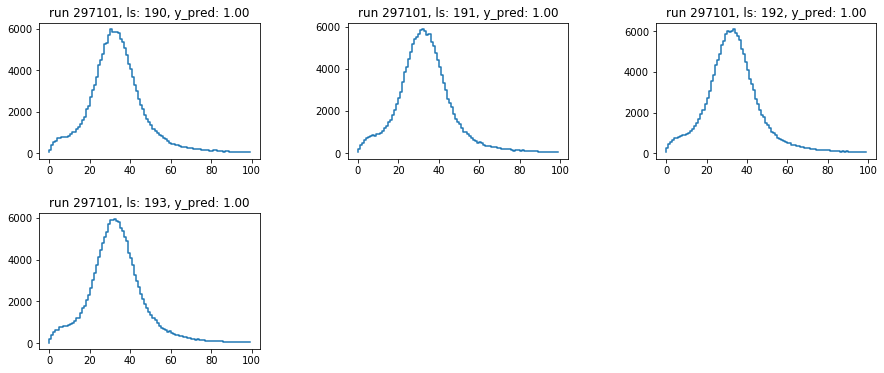

BAD LS


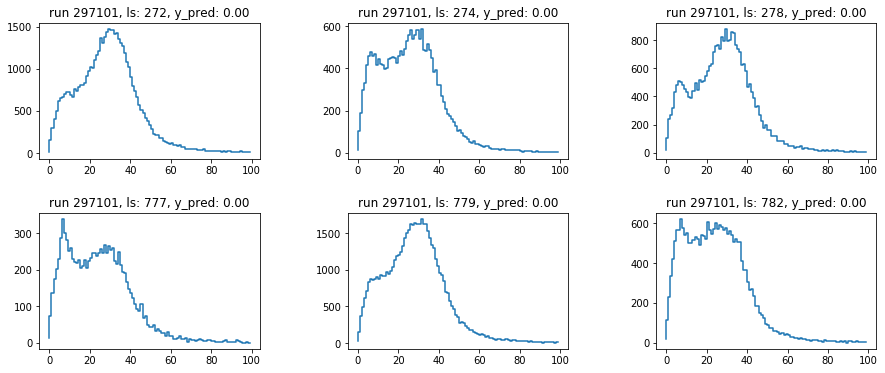

ANOMALOUS LS


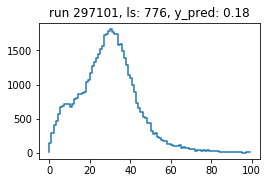

Training set shape (5492, 121)
Explained variance ratio [0.90076066 0.08498805 0.00331369 0.00179935]


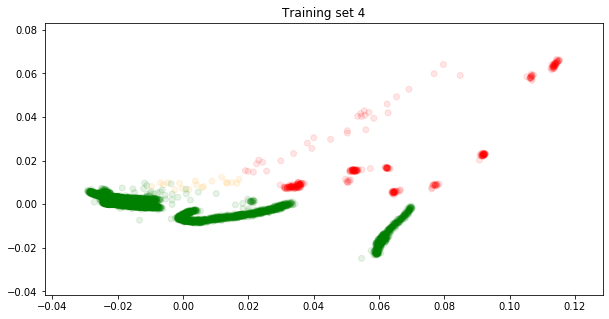

Training model
Epoch 00112: early stopping
Accuracy 1.0
[[  78    0]
 [   0 1295]]

********************************************************************************
Classifying Run 297113

Explained variance ratio [0.64772268 0.1421538  0.05741199 0.01768059]


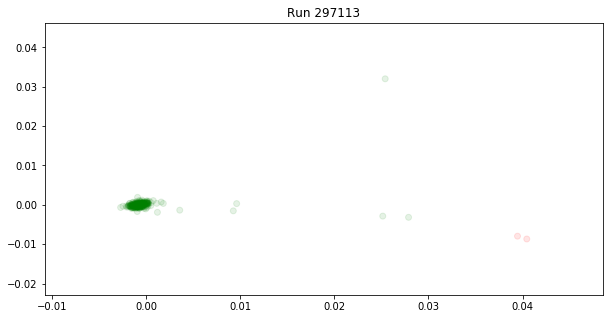

Good LS: 239 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 22

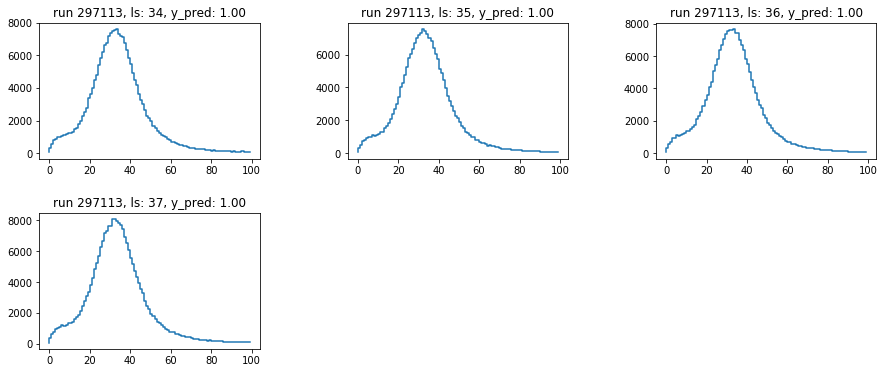

BAD LS


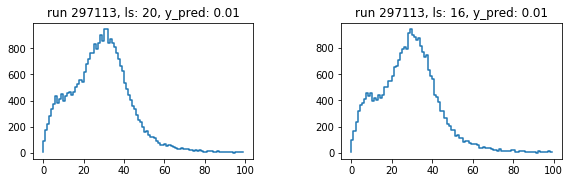

ANOMALOUS LS
Training set shape (5733, 121)
Explained variance ratio [0.90149559 0.08376824 0.00341577 0.00181558]


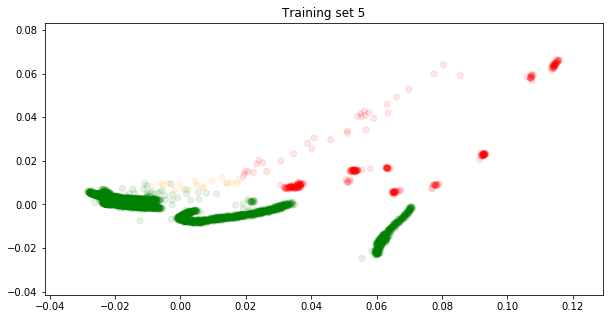

Training model
Epoch 00083: early stopping
Accuracy 1.0
[[  79    0]
 [   0 1355]]

********************************************************************************
Classifying Run 297114

Explained variance ratio [0.47187337 0.32183408 0.03316011 0.01360935]


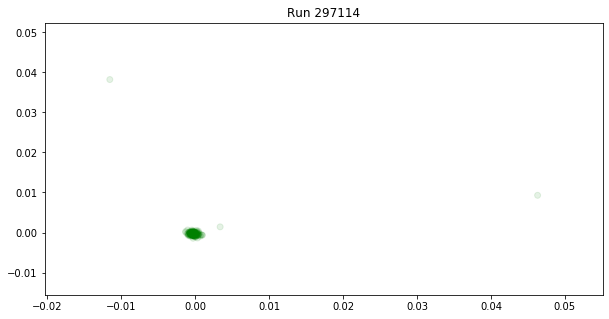

Good LS: 162 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


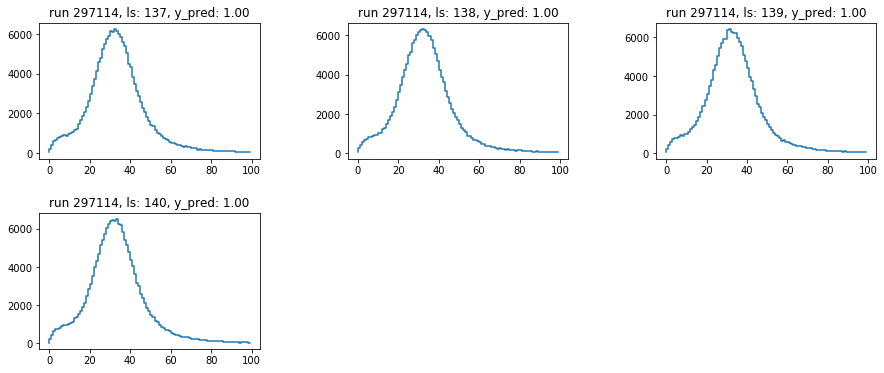

BAD LS
ANOMALOUS LS
Training set shape (5895, 121)
Explained variance ratio [0.90176453 0.08286826 0.00342978 0.00182026]


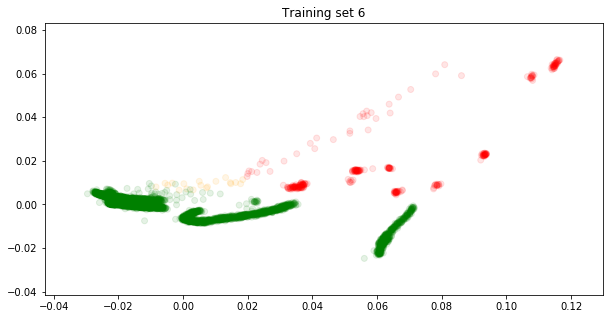

Training model
Epoch 00119: early stopping
Accuracy 1.0
[[  79    0]
 [   0 1395]]

********************************************************************************
Classifying Run 297168

Explained variance ratio [0.55080975 0.085428   0.0746647  0.04752504]


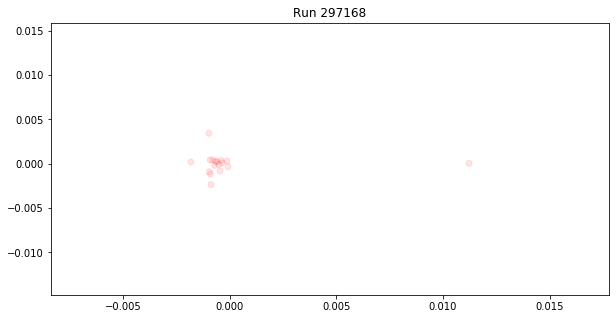

Good LS: 0 []
Bad LS: 17 [38, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56]
Anomalies LS: 0 []
GOOD LS
BAD LS


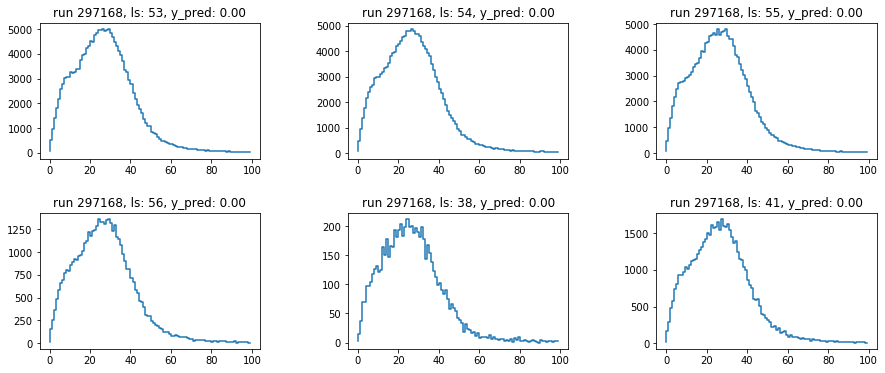

ANOMALOUS LS
Training set shape (5912, 121)
Explained variance ratio [0.90191734 0.08275832 0.0034133  0.00181623]


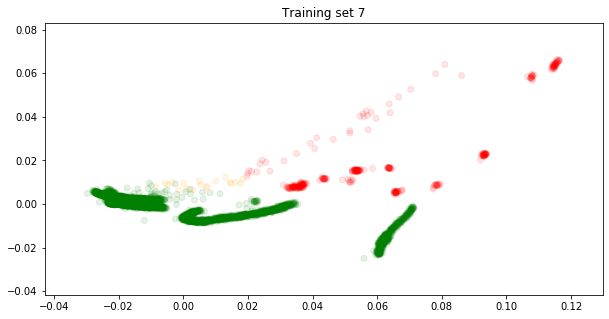

Training model
Epoch 00091: early stopping
Accuracy 1.0
[[  83    0]
 [   0 1395]]

********************************************************************************
Classifying Run 297169

Explained variance ratio [0.97722009 0.00594466 0.00466752 0.00363842]


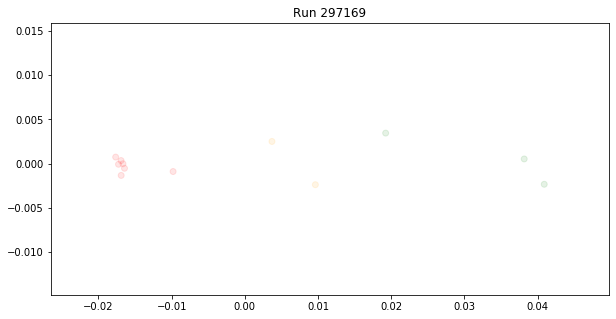

Good LS: 3 [2, 3, 5]
Bad LS: 7 [6, 7, 8, 9, 10, 11, 12]
Anomalies LS: 2 [1, 4]
GOOD LS


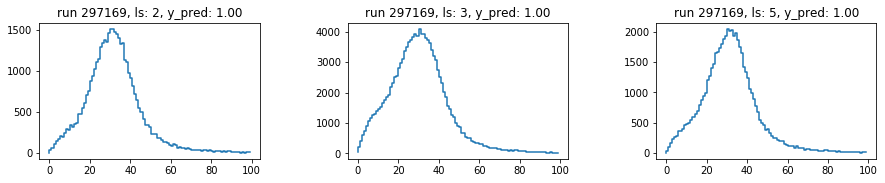

BAD LS


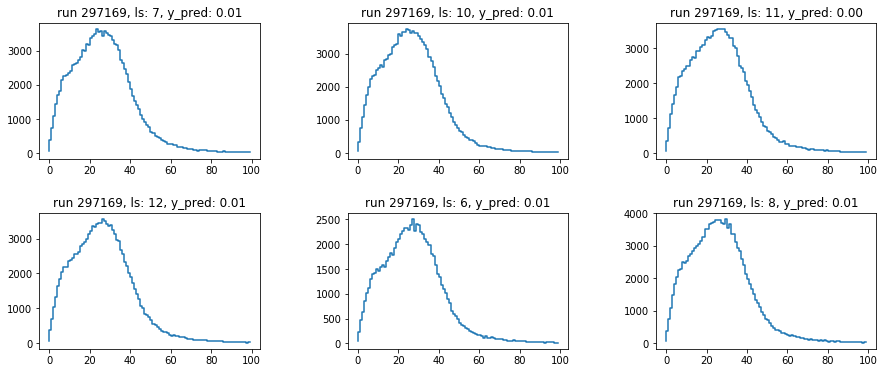

ANOMALOUS LS


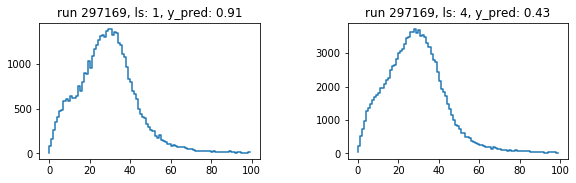

Training set shape (5922, 121)
Explained variance ratio [0.90192951 0.08274641 0.00341278 0.00181851]


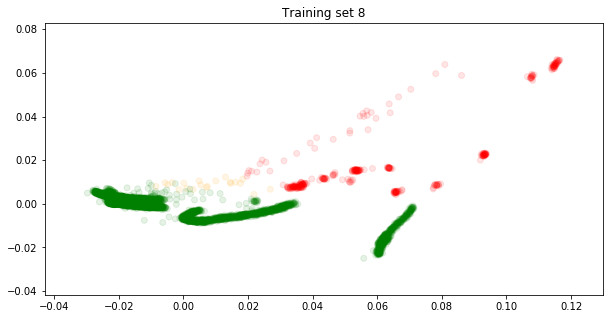

Training model
Epoch 00103: early stopping
Accuracy 1.0
[[  85    0]
 [   0 1396]]

********************************************************************************
Classifying Run 297175

Explained variance ratio [0.1877493  0.07531626 0.0524396  0.05053793]


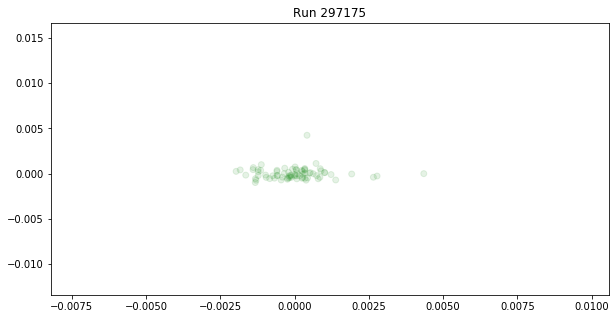

Good LS: 75 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


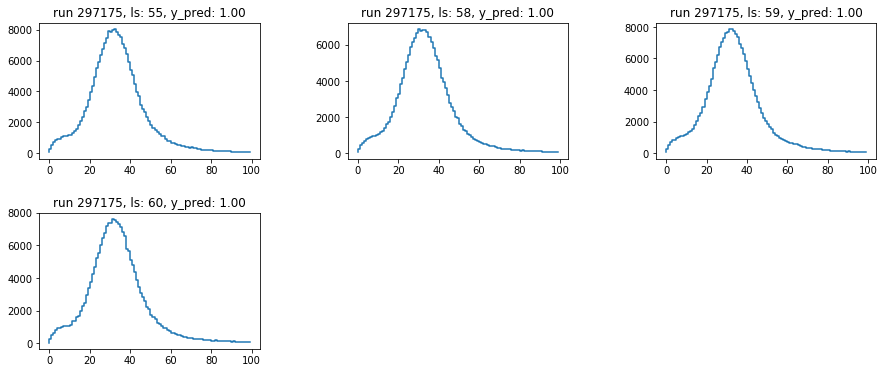

BAD LS
ANOMALOUS LS
Training set shape (5997, 121)
Explained variance ratio [0.90223398 0.08240755 0.00340296 0.00181771]


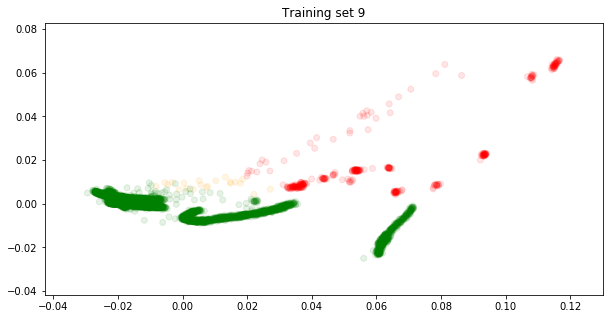

Training model
Epoch 00131: early stopping
Accuracy 1.0
[[  85    0]
 [   0 1415]]

********************************************************************************
Classifying Run 297176

Explained variance ratio [0.48156088 0.02769562 0.0261655  0.02563542]


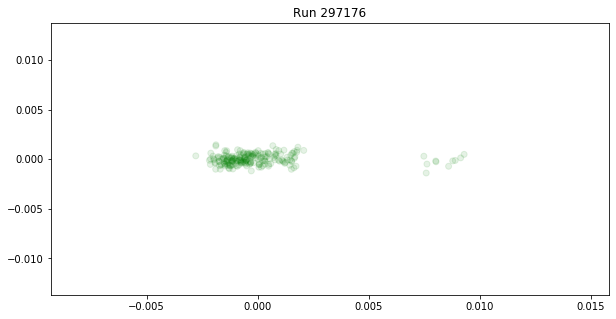

Good LS: 210 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


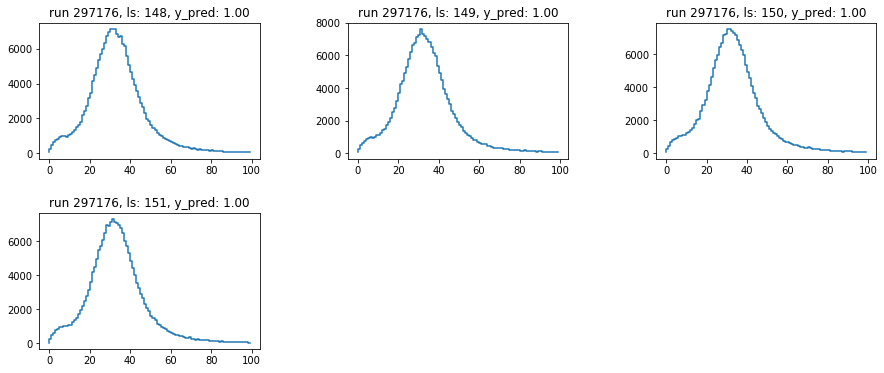

BAD LS
ANOMALOUS LS
Training set shape (6207, 121)
Explained variance ratio [0.90279    0.08173016 0.00338393 0.00181517]


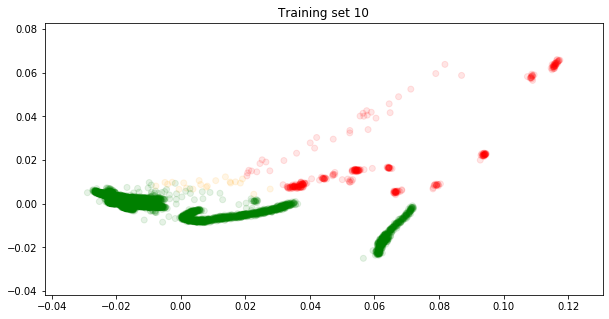

Training model
Epoch 00113: early stopping
Accuracy 1.0
[[  85    0]
 [   0 1467]]

********************************************************************************
Classifying Run 297177

Explained variance ratio [0.4741838  0.02874529 0.02729751 0.02531004]


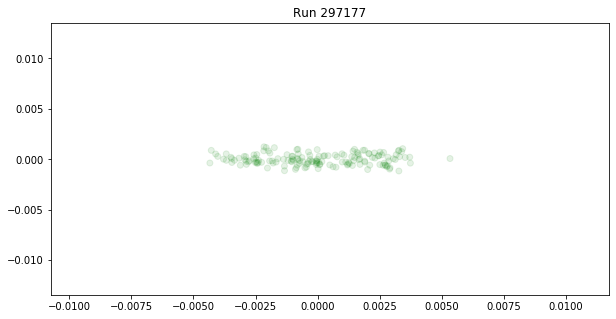

Good LS: 157 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


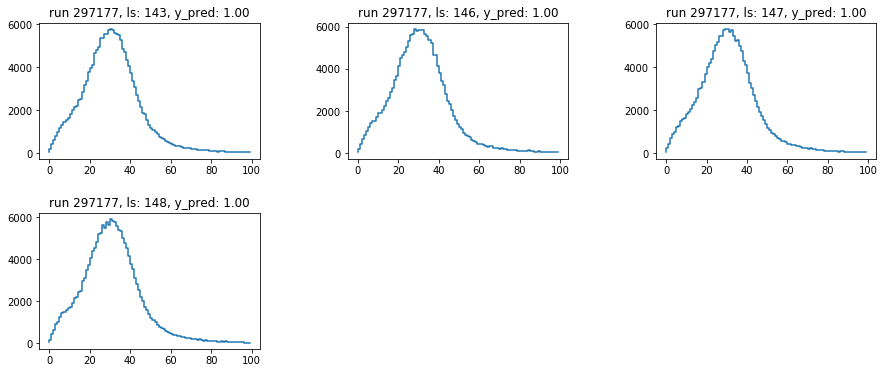

BAD LS
ANOMALOUS LS
Training set shape (6364, 121)
Explained variance ratio [0.9027442  0.08152614 0.00348435 0.00184646]


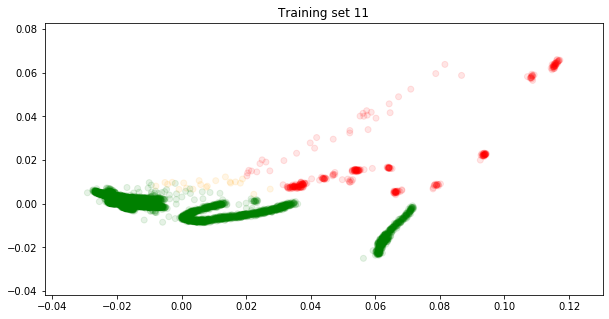

Training model
Epoch 00088: early stopping
Accuracy 1.0
[[  85    0]
 [   0 1506]]

********************************************************************************
Classifying Run 297179

Explained variance ratio [0.54050441 0.27460709 0.03176575 0.01253855]


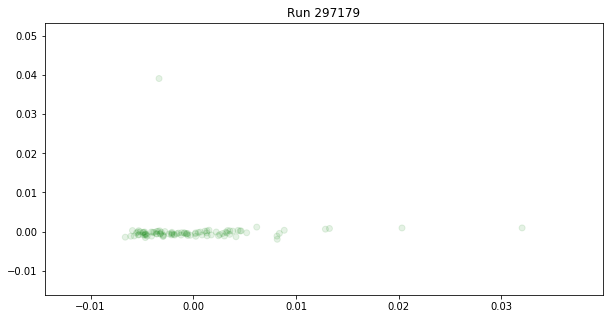

Good LS: 92 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


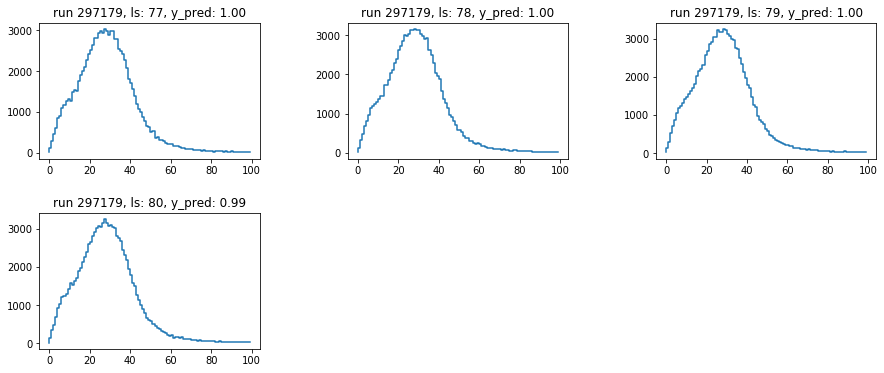

BAD LS
ANOMALOUS LS
Training set shape (6456, 121)
Explained variance ratio [0.9030685  0.08081995 0.00345605 0.00193073]


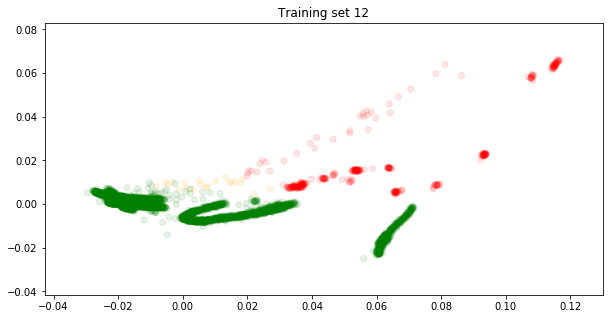

Training model
Epoch 00130: early stopping
Accuracy 1.0
[[  84    0]
 [   0 1530]]

********************************************************************************
Classifying Run 297180

Explained variance ratio [0.69982363 0.22809309 0.00457988 0.0039503 ]


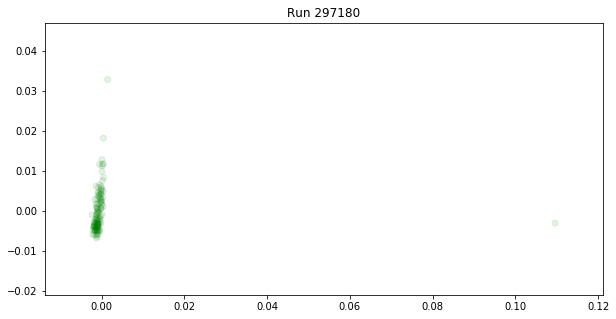

Good LS: 129 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


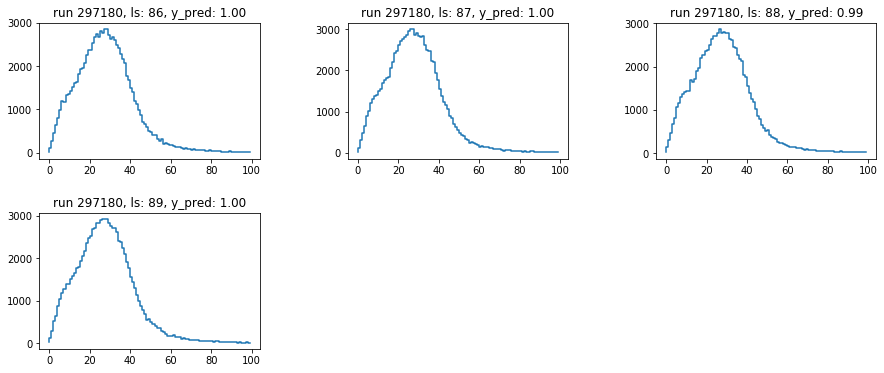

BAD LS
ANOMALOUS LS
Training set shape (6585, 121)
Explained variance ratio [0.90268273 0.07917436 0.00340718 0.0022337 ]


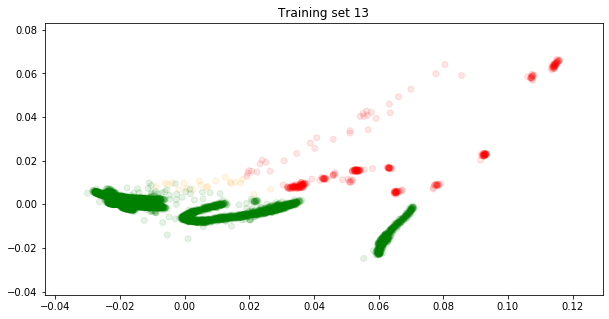

Training model
Epoch 00102: early stopping
Accuracy 1.0
[[  85    0]
 [   0 1562]]

********************************************************************************
Classifying Run 297181

Explained variance ratio [0.93511378 0.03465915 0.00560621 0.00297418]


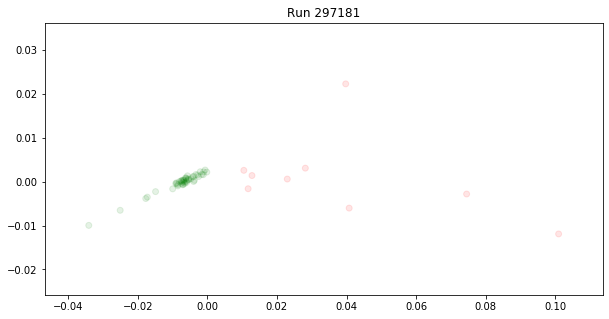

Good LS: 47 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 40, 45, 48, 49, 50, 51, 52, 53, 54, 55]
Bad LS: 9 [38, 39, 41, 42, 43, 44, 46, 47, 56]
Anomalies LS: 0 []
GOOD LS


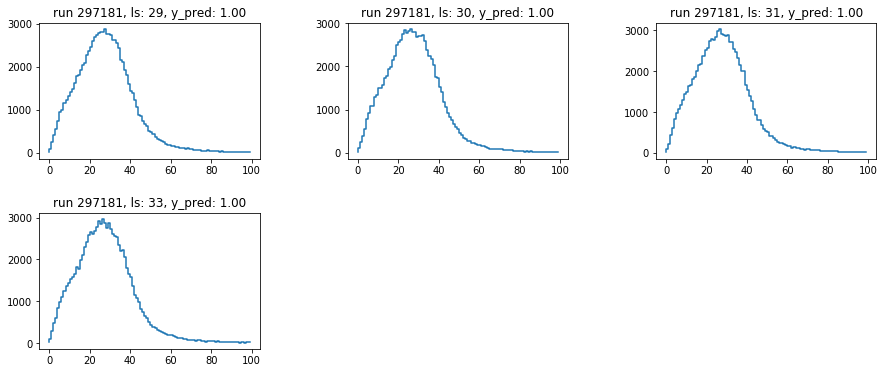

BAD LS


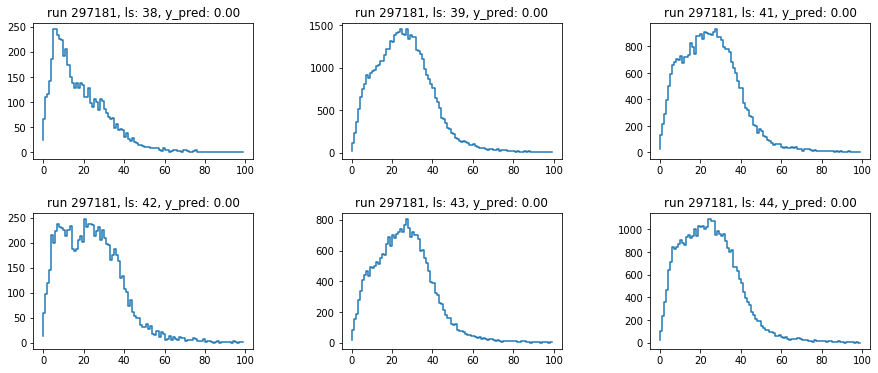

ANOMALOUS LS
Training set shape (6641, 121)
Explained variance ratio [0.9020292  0.07978209 0.00343656 0.00219783]


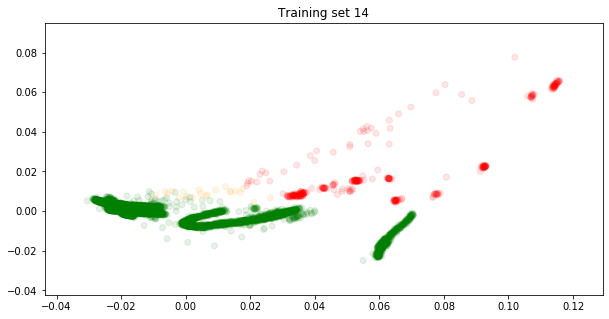

Training model
Epoch 00110: early stopping
Accuracy 1.0
[[  87    0]
 [   0 1574]]

********************************************************************************
Classifying Run 297211

Explained variance ratio [0.96300404 0.00815317 0.0070235  0.00276707]


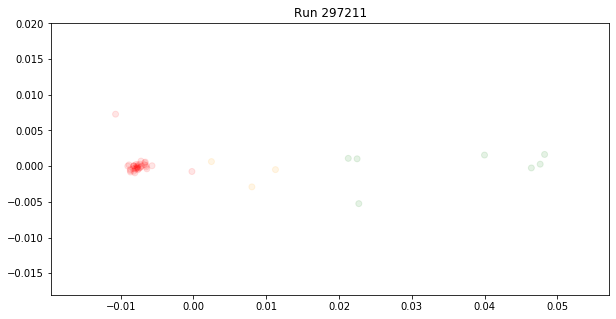

Good LS: 7 [34, 35, 36, 37, 39, 40, 42]
Bad LS: 36 [28, 31, 32, 33, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75]
Anomalies LS: 3 [38, 41, 43]
GOOD LS


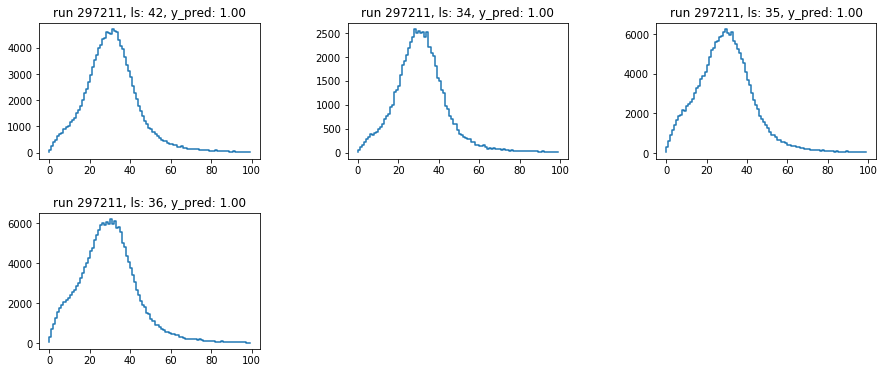

BAD LS


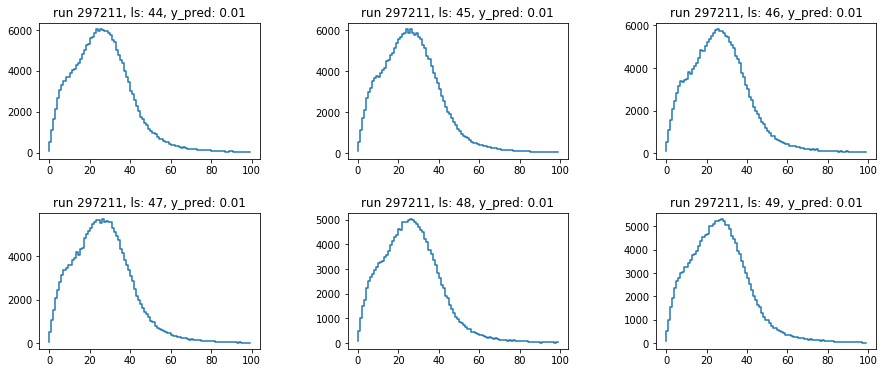

ANOMALOUS LS


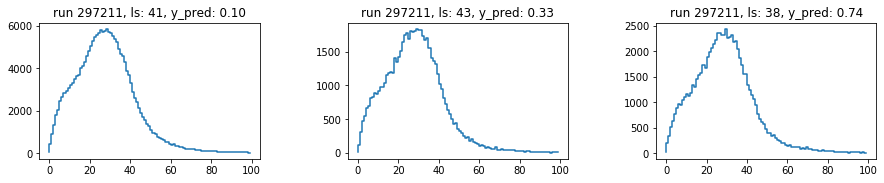

Training set shape (6684, 121)
Explained variance ratio [0.90242951 0.07948532 0.00342487 0.0021721 ]


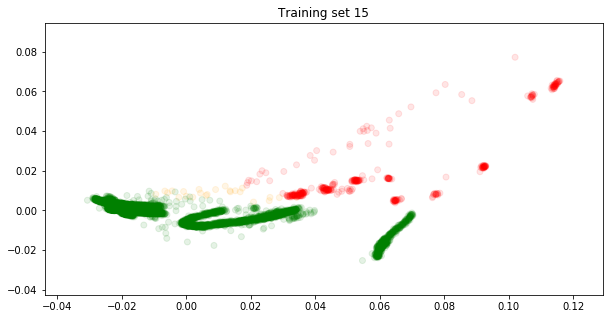

Training model
Epoch 00117: early stopping
Accuracy 1.0
[[  96    0]
 [   0 1575]]

********************************************************************************
Classifying Run 297215

Explained variance ratio [0.21977555 0.08704365 0.05397695 0.0495534 ]


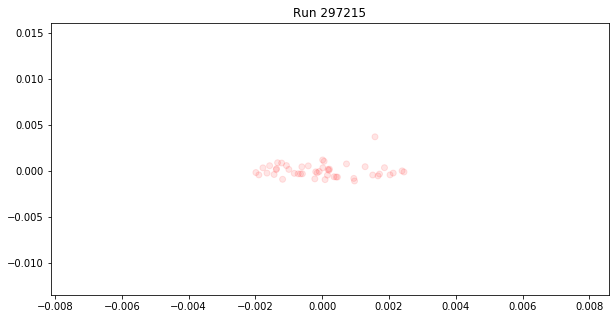

Good LS: 0 []
Bad LS: 47 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47]
Anomalies LS: 0 []
GOOD LS
BAD LS


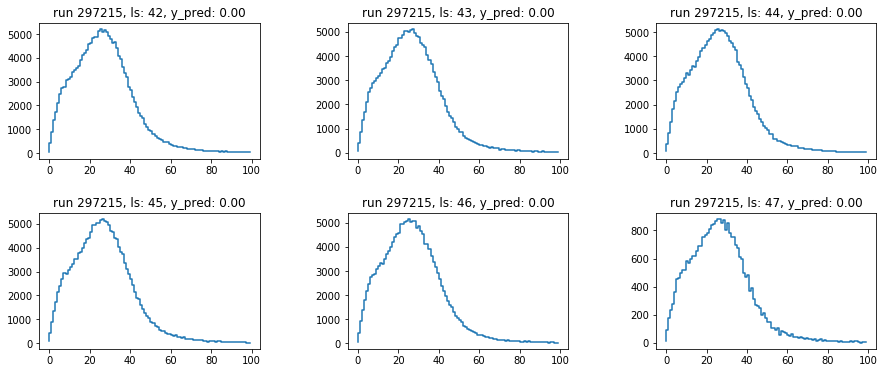

ANOMALOUS LS
Training set shape (6731, 121)
Explained variance ratio [0.90319327 0.07892972 0.00338869 0.00213847]


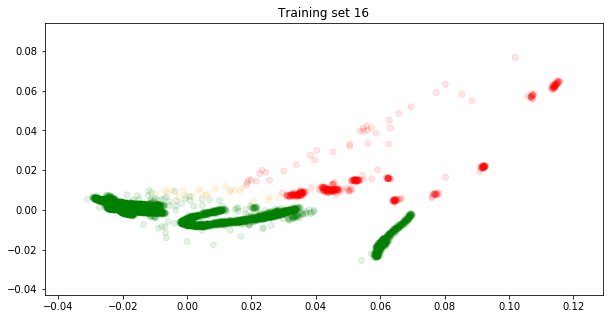

Training model
Epoch 00068: early stopping
Accuracy 1.0
[[ 108    0]
 [   0 1575]]

********************************************************************************
Classifying Run 297218

Explained variance ratio [0.22387065 0.1371262  0.11567247 0.08958345]


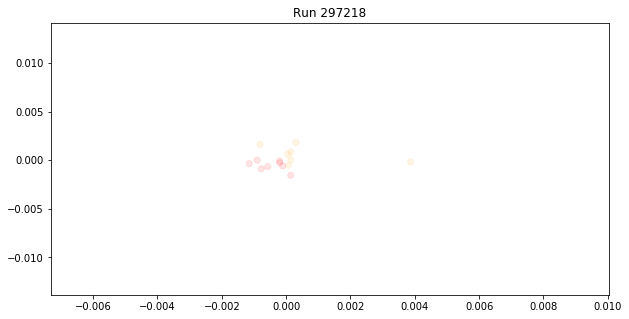

Good LS: 0 []
Bad LS: 8 [1, 2, 3, 6, 7, 10, 11, 13]
Anomalies LS: 7 [4, 5, 8, 9, 12, 14, 15]
GOOD LS
BAD LS


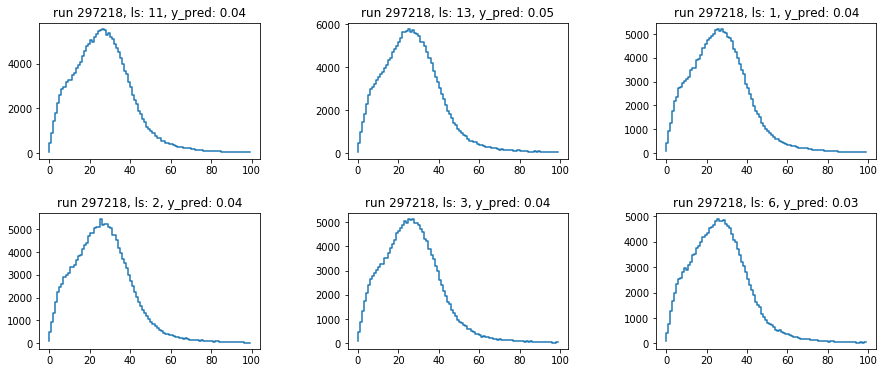

ANOMALOUS LS


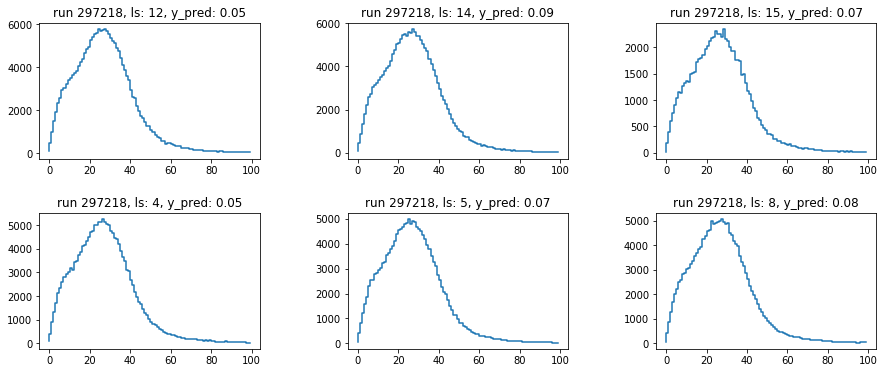

Training set shape (6739, 121)
Explained variance ratio [0.90343415 0.07874011 0.00338176 0.00212969]


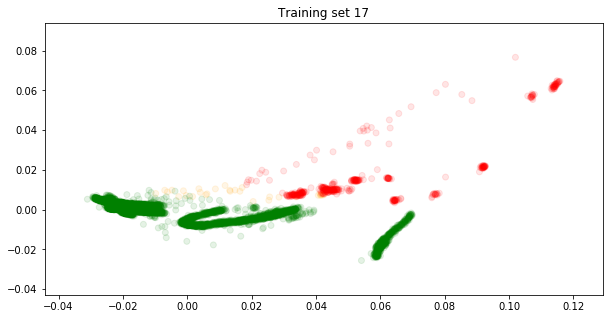

Training model
Epoch 00078: early stopping
Accuracy 1.0
[[ 110    0]
 [   0 1575]]

********************************************************************************
Classifying Run 297219

Explained variance ratio [0.85717917 0.10737877 0.0043606  0.00419314]


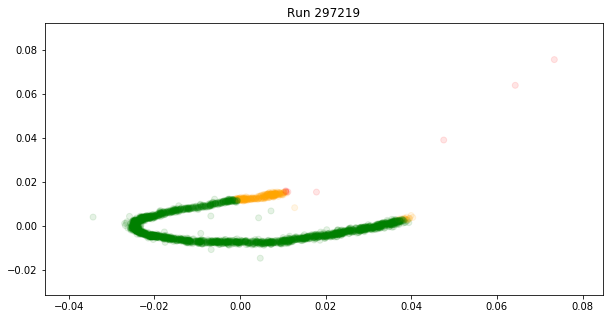

Good LS: 2366 [66, 67, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 244, 245, 246, 247, 248, 276, 278, 279, 280, 281, 282, 284, 285, 286, 287, 288, 289, 290, 291, 292, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303, 304, 305, 306, 307, 308, 309, 310, 311, 312, 313, 314, 315, 316, 317, 318, 319, 320, 321, 322, 323, 324, 325, 326, 327, 328, 329, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 371, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426, 427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439, 440, 441, 442, 443, 444, 445, 446, 447, 44

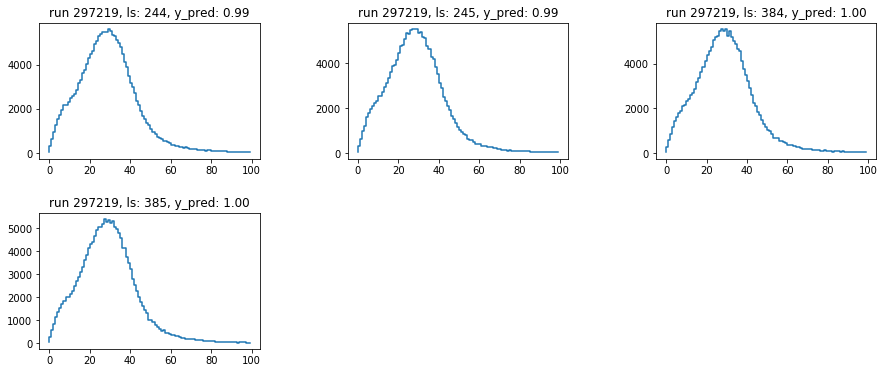

BAD LS


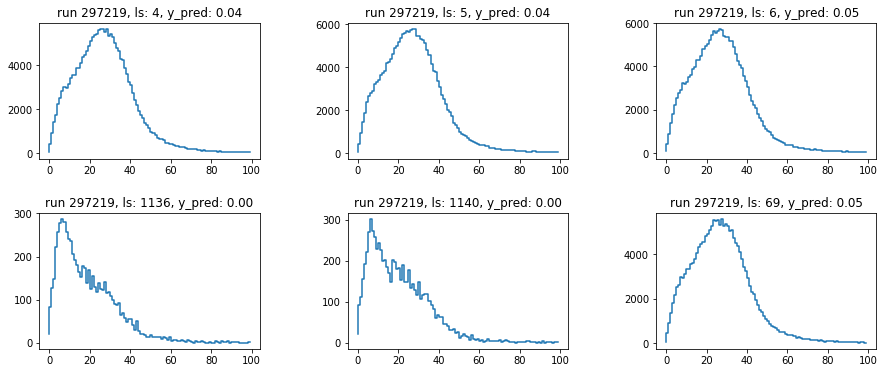

ANOMALOUS LS


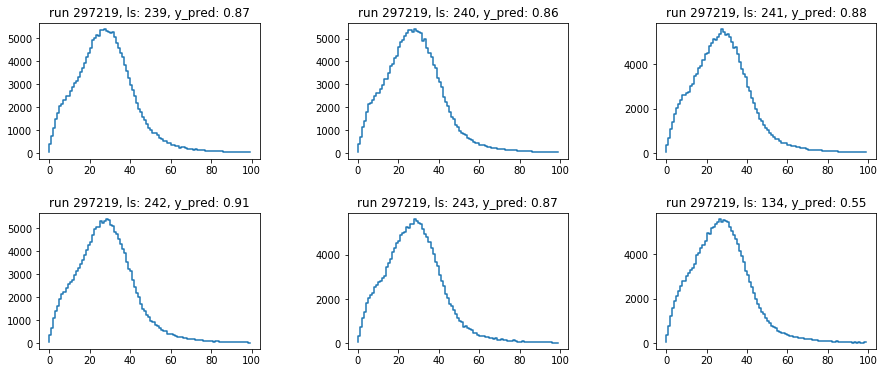

Training set shape (9113, 121)
Explained variance ratio [0.90250824 0.0806036  0.00281981 0.00152649]


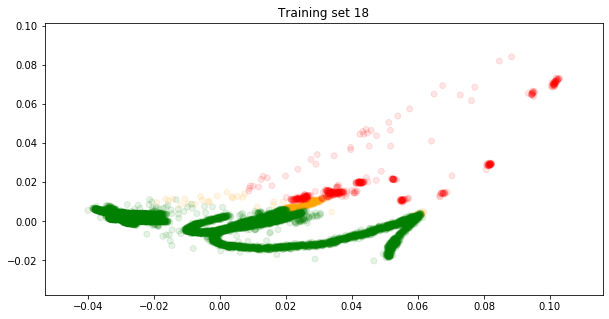

Training model
Epoch 00071: early stopping
Accuracy 1.0
[[ 112    0]
 [   0 2167]]

********************************************************************************
Classifying Run 297224

Explained variance ratio [0.5561194  0.09197242 0.02400348 0.02124969]


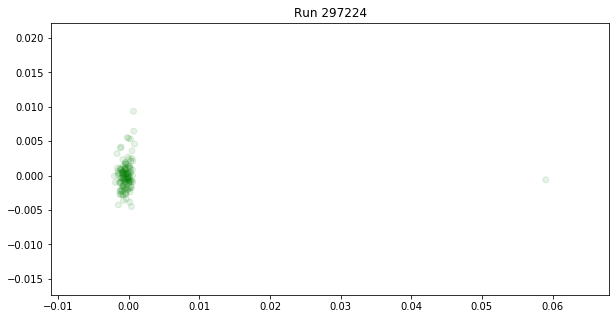

Good LS: 138 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


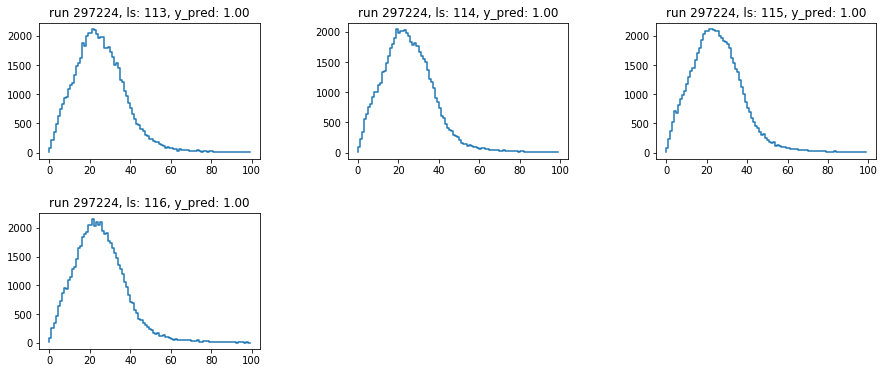

BAD LS
ANOMALOUS LS
Training set shape (9251, 121)
Explained variance ratio [0.9050229  0.0779334  0.00277147 0.00149375]


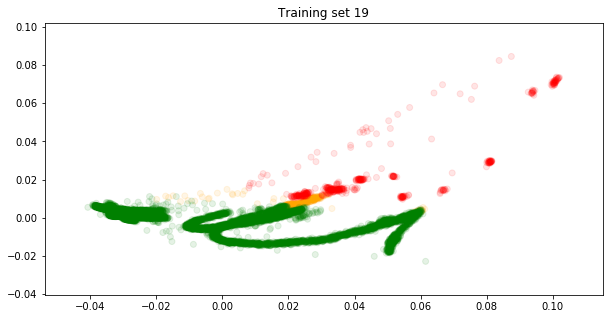

Training model
Epoch 00073: early stopping
Accuracy 1.0
[[ 112    0]
 [   0 2201]]

********************************************************************************
Classifying Run 297225

Explained variance ratio [0.32839863 0.09315074 0.06844678 0.05980532]


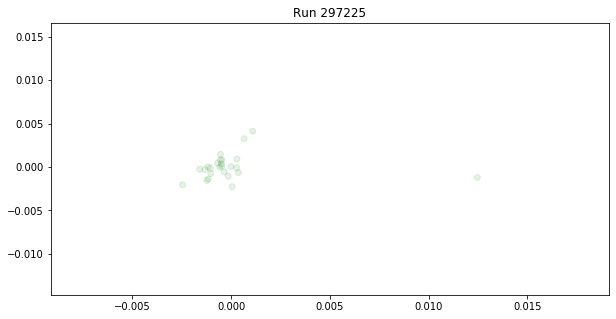

Good LS: 25 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


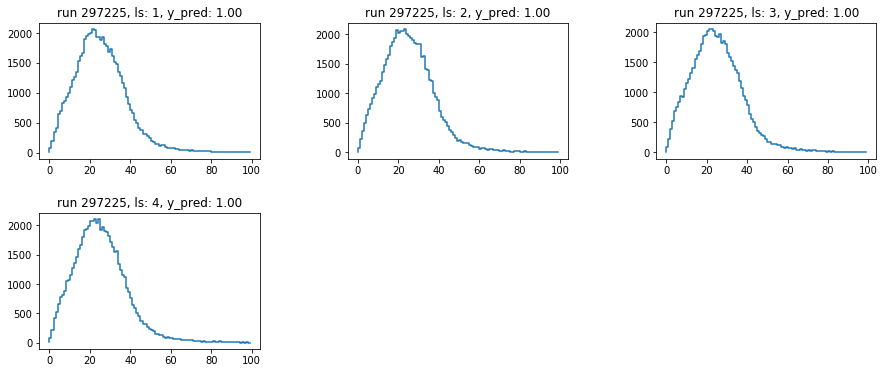

BAD LS
ANOMALOUS LS
Training set shape (9276, 121)
Explained variance ratio [0.90554379 0.07742761 0.00276509 0.00148554]


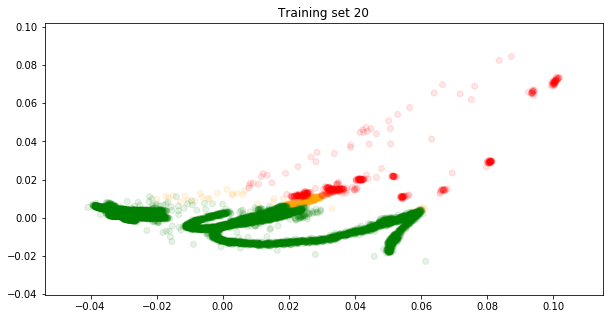

Training model
Epoch 00113: early stopping
Accuracy 1.0
[[ 112    0]
 [   0 2207]]

********************************************************************************
Classifying Run 297227

Explained variance ratio [0.9202875  0.02036456 0.0061848  0.00349785]


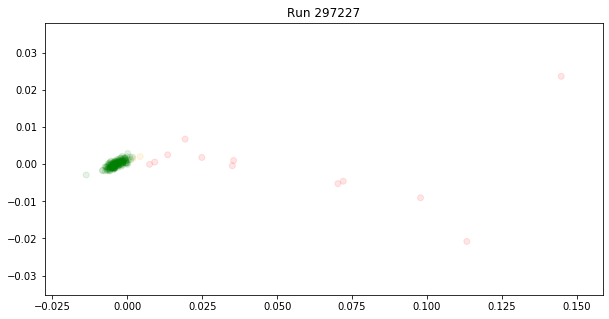

Good LS: 179 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190]
Bad LS: 12 [169, 170, 171, 172, 173, 174, 175, 176, 178, 179, 192, 193]
Anomalies LS: 2 [177, 191]
GOOD LS


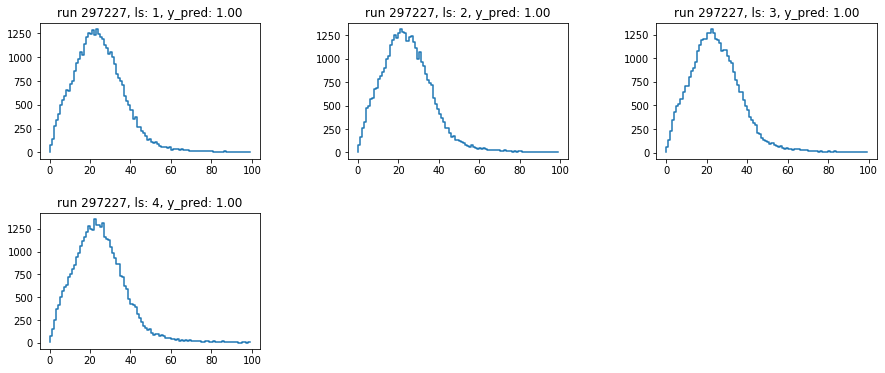

BAD LS


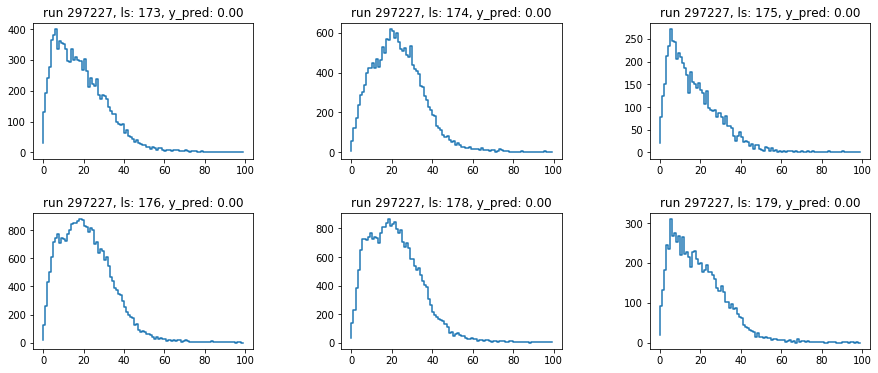

ANOMALOUS LS


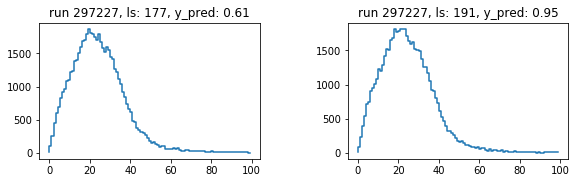

Training set shape (9467, 121)
Explained variance ratio [0.9061713  0.07694448 0.00284763 0.0014179 ]


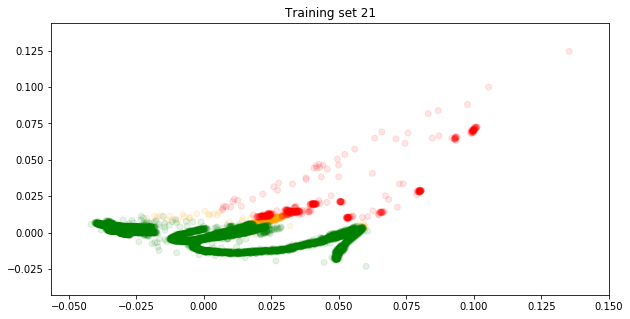

Training model
Epoch 00073: early stopping
Accuracy 1.0
[[ 115    0]
 [   0 2252]]

********************************************************************************
Classifying Run 297282

Explained variance ratio [0.48807875 0.09152552 0.06316792 0.05832288]


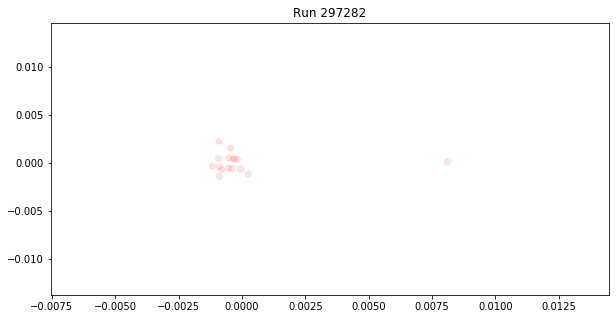

Good LS: 0 []
Bad LS: 16 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]
Anomalies LS: 0 []
GOOD LS
BAD LS


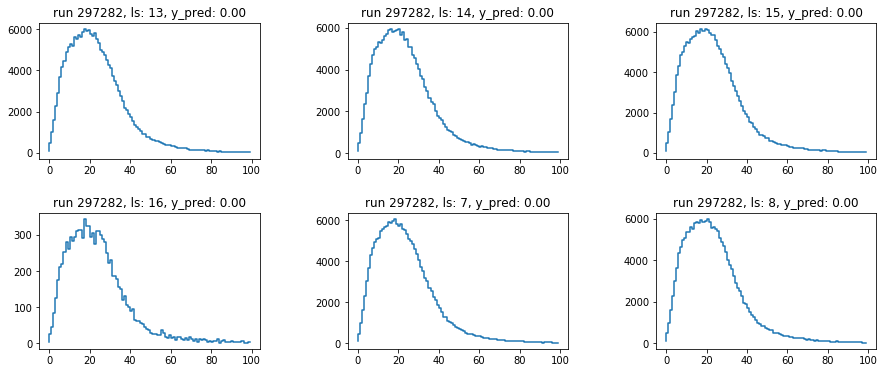

ANOMALOUS LS
Training set shape (9483, 121)
Explained variance ratio [0.9059068  0.07722798 0.00288528 0.00140572]


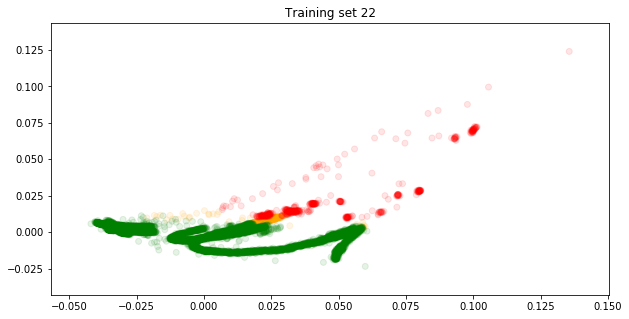

Training model
Epoch 00068: early stopping
Accuracy 1.0
[[ 119    0]
 [   0 2252]]

********************************************************************************
Classifying Run 297283

Explained variance ratio [0.16521814 0.13602566 0.12120337 0.11091802]


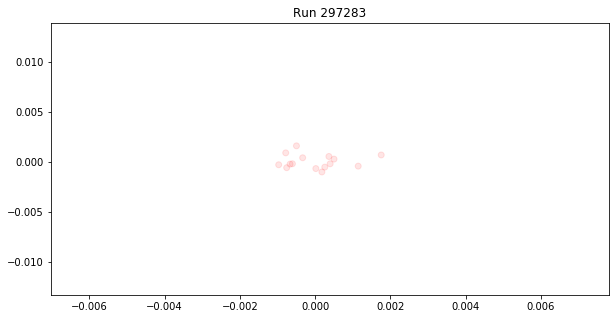

Good LS: 0 []
Bad LS: 15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Anomalies LS: 0 []
GOOD LS
BAD LS


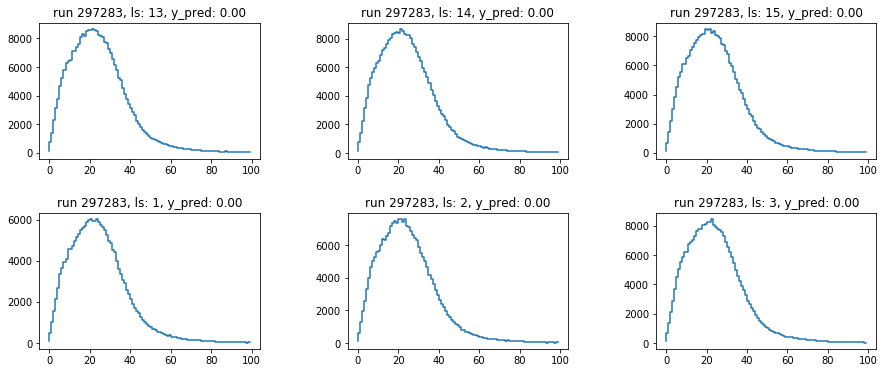

ANOMALOUS LS
Training set shape (9498, 121)
Explained variance ratio [0.90599004 0.07719165 0.00289235 0.00139855]


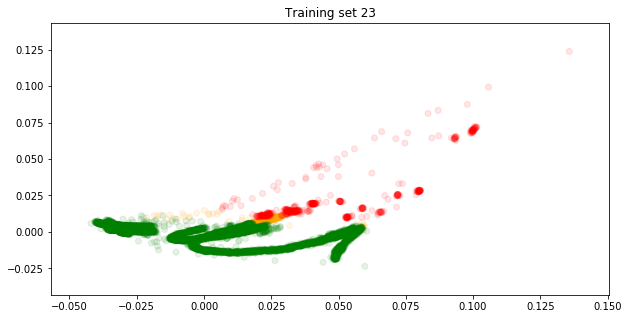

Training model
Epoch 00090: early stopping
Accuracy 1.0
[[ 122    0]
 [   0 2253]]

********************************************************************************
Classifying Run 297285

Explained variance ratio [0.98345093 0.00781884 0.00234876 0.00170219]


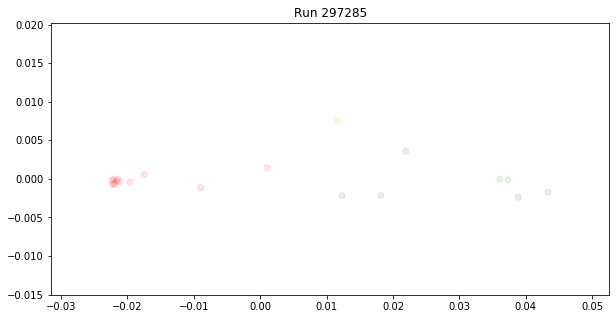

Good LS: 7 [5, 7, 8, 10, 11, 12, 13]
Bad LS: 12 [1, 2, 3, 6, 9, 14, 15, 16, 17, 18, 19, 20]
Anomalies LS: 1 [4]
GOOD LS


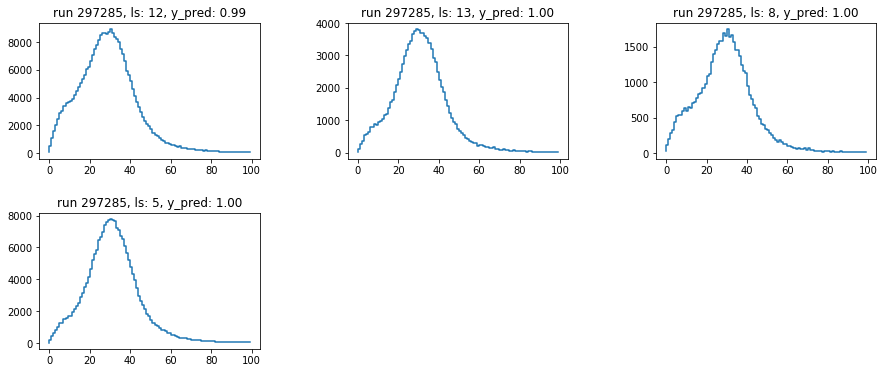

BAD LS


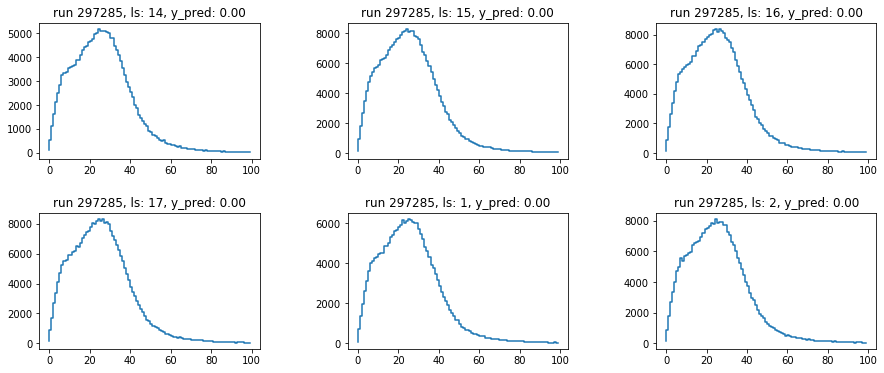

ANOMALOUS LS


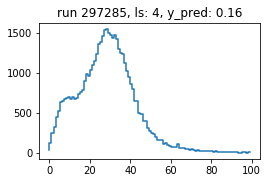

Training set shape (9517, 121)
Explained variance ratio [0.90581103 0.07737237 0.0028994  0.00139634]


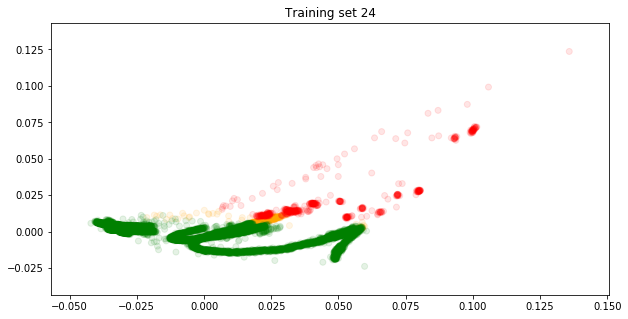

Training model
Epoch 00087: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2255]]

********************************************************************************
Classifying Run 297287

Explained variance ratio [0.5404742  0.07432947 0.06567407 0.05254541]


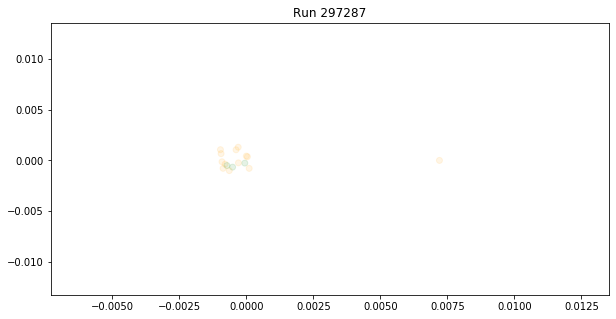

Good LS: 3 [11, 14, 15]
Bad LS: 0 []
Anomalies LS: 13 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 16]
GOOD LS


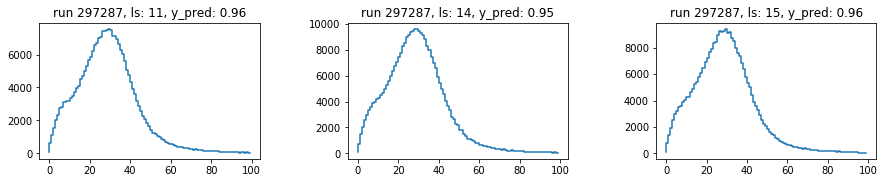

BAD LS
ANOMALOUS LS


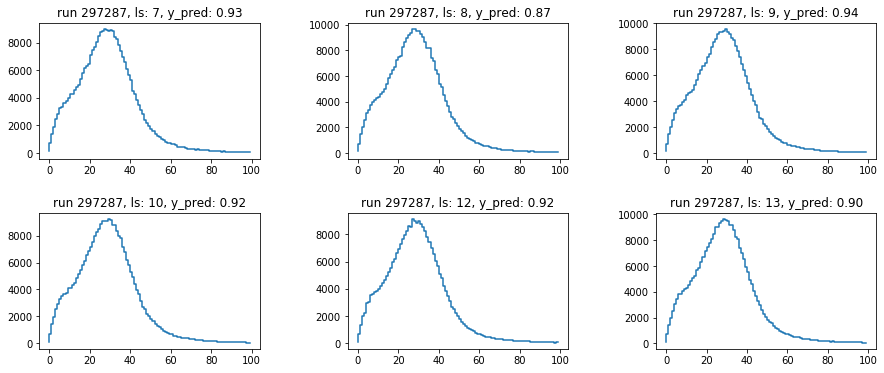

Training set shape (9520, 121)
Explained variance ratio [0.90574998 0.07742515 0.00289929 0.00139657]


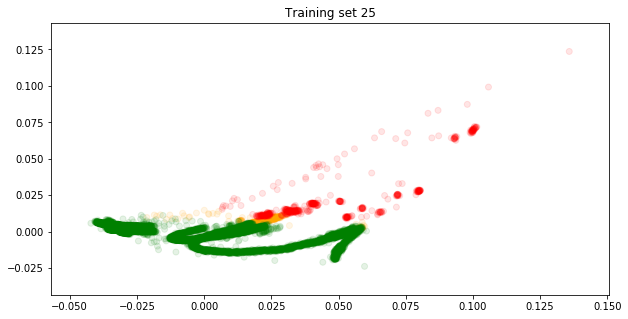

Training model
Epoch 00081: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2255]]

********************************************************************************
Classifying Run 297288

Explained variance ratio [0.17608653 0.14280351 0.12881575 0.10372949]


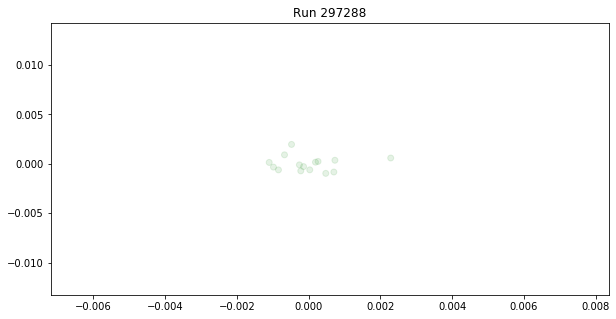

Good LS: 15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


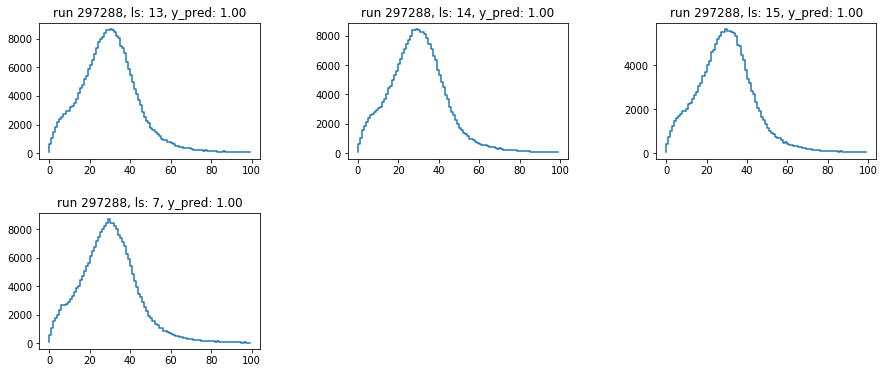

BAD LS
ANOMALOUS LS
Training set shape (9535, 121)
Explained variance ratio [0.90571322 0.07745458 0.00289949 0.00139715]


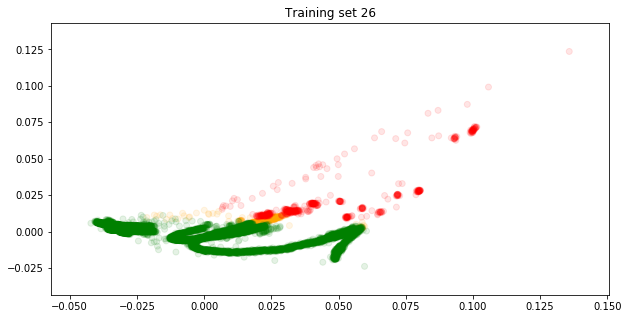

Training model
Epoch 00101: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2259]]

********************************************************************************
Classifying Run 297289

Explained variance ratio [0.22518064 0.1435798  0.11241329 0.08491791]


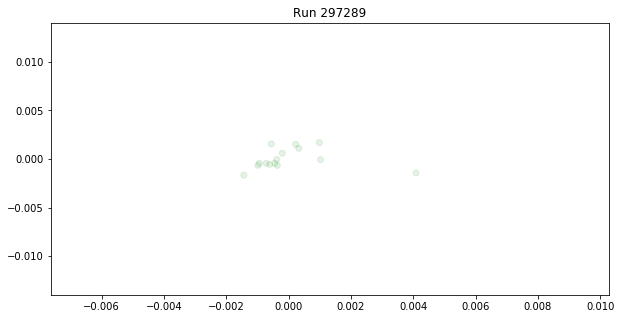

Good LS: 15 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


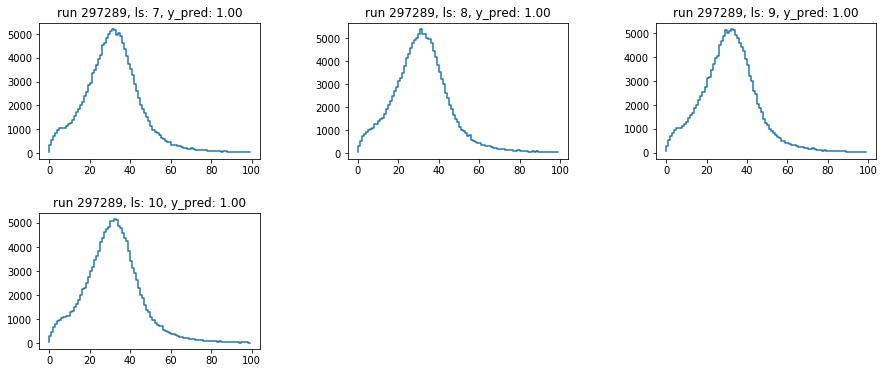

BAD LS
ANOMALOUS LS
Training set shape (9550, 121)
Explained variance ratio [0.9056975  0.07745045 0.00290412 0.00139674]


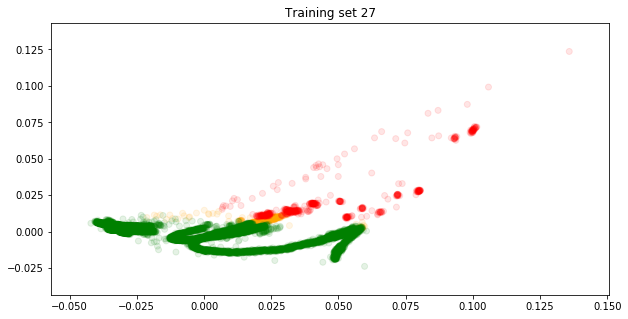

Training model
Epoch 00070: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2263]]

********************************************************************************
Classifying Run 297290

Explained variance ratio [0.70085004 0.0752365  0.04031927 0.03329943]


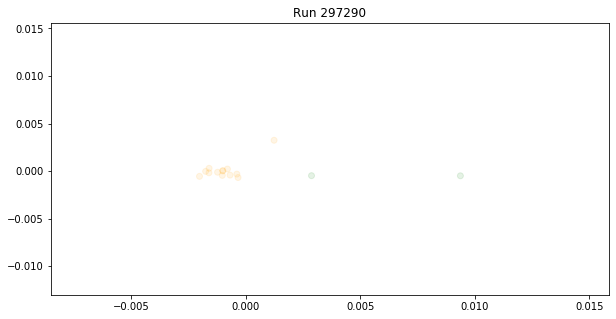

Good LS: 2 [1, 2]
Bad LS: 0 []
Anomalies LS: 13 [3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
GOOD LS


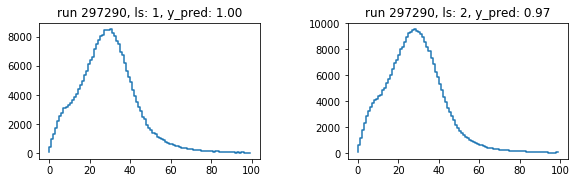

BAD LS
ANOMALOUS LS


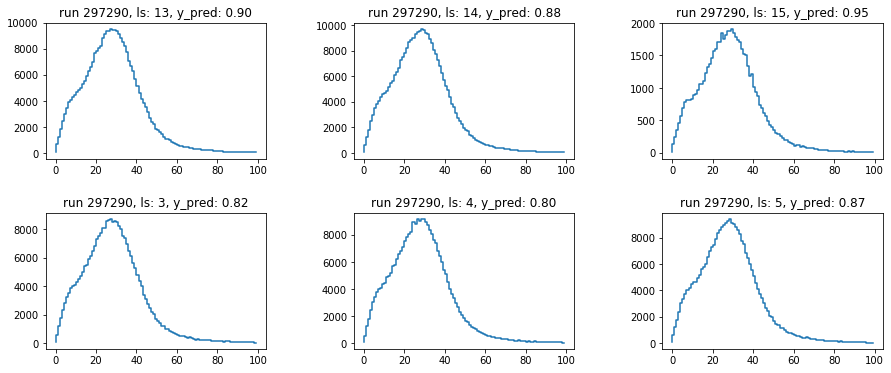

Training set shape (9552, 121)
Explained variance ratio [0.90568032 0.07746726 0.00290279 0.00139612]


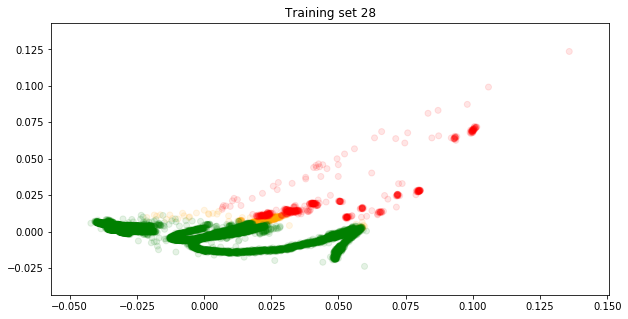

Training model
Epoch 00080: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2263]]

********************************************************************************
Classifying Run 297291

Explained variance ratio [0.1729952  0.134933   0.11129879 0.08645673]


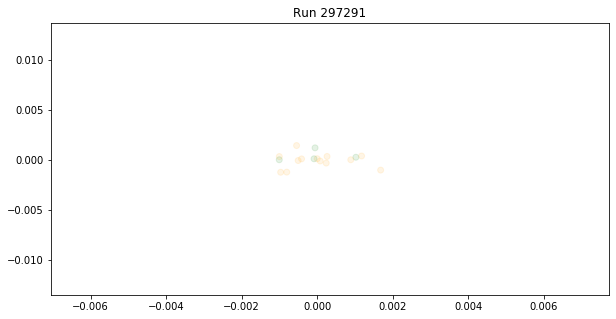

Good LS: 4 [4, 6, 12, 13]
Bad LS: 0 []
Anomalies LS: 13 [1, 2, 3, 5, 7, 8, 9, 10, 11, 14, 15, 16, 17]
GOOD LS


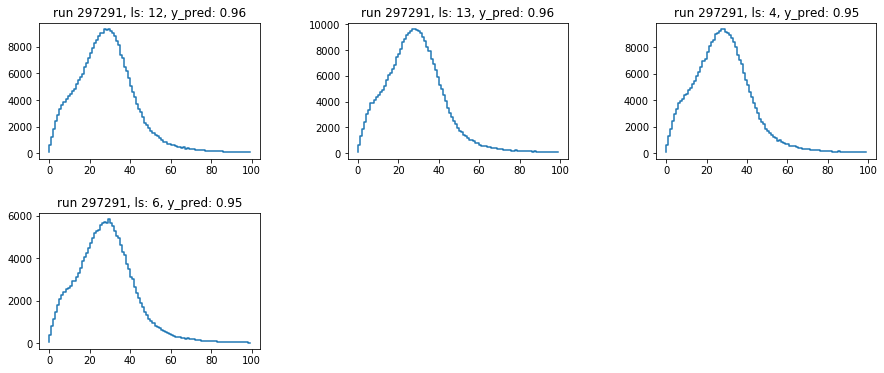

BAD LS
ANOMALOUS LS


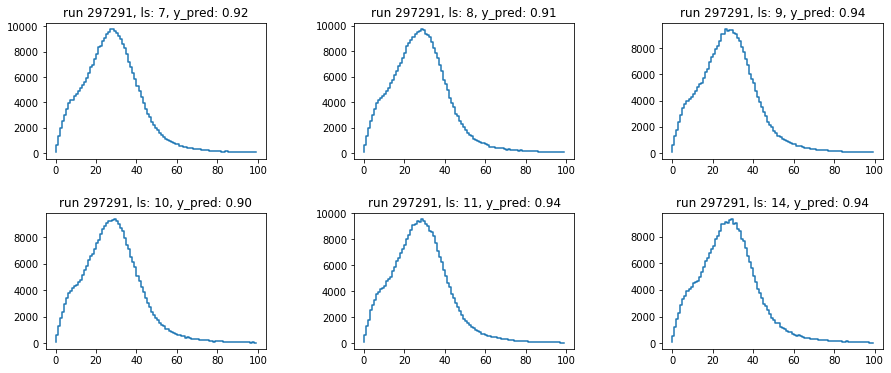

Training set shape (9556, 121)
Explained variance ratio [0.90565957 0.07748775 0.00290159 0.0013956 ]


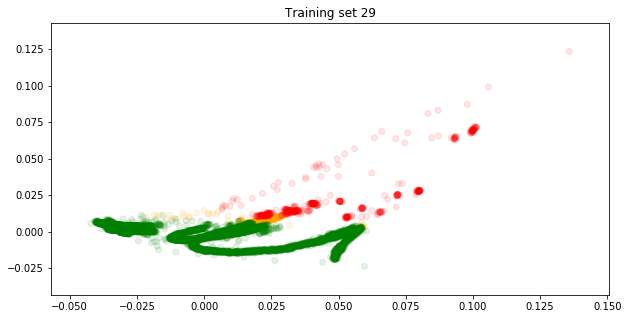

Training model
Epoch 00068: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2264]]

********************************************************************************
Classifying Run 297292

Explained variance ratio [0.9546885  0.01270085 0.00323911 0.00262293]


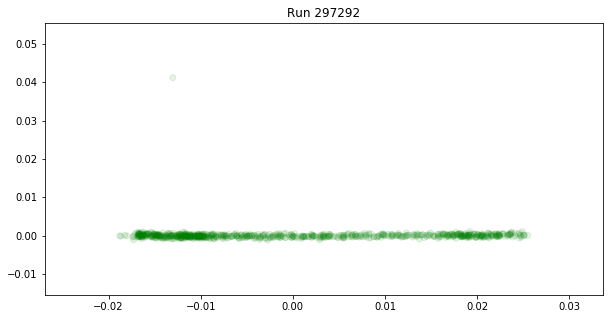

Good LS: 748 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

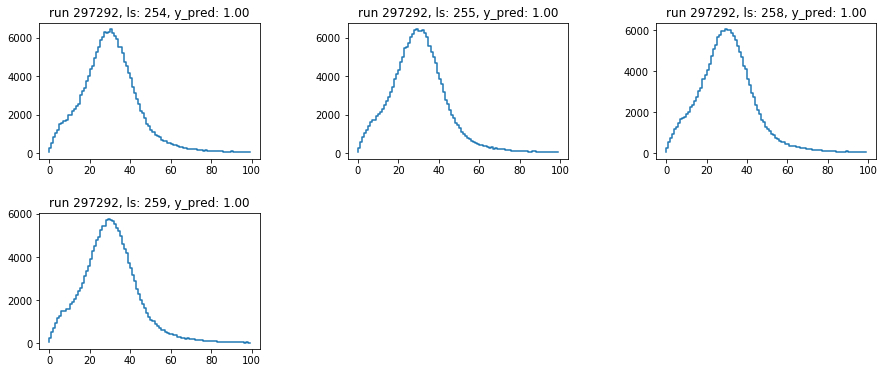

BAD LS
ANOMALOUS LS
Training set shape (10304, 121)
Explained variance ratio [0.90418351 0.07826889 0.00318004 0.00140891]


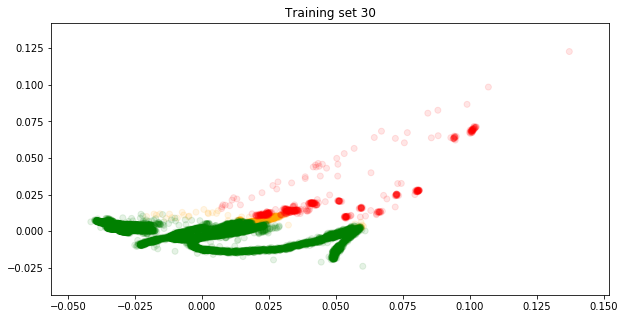

Training model
Epoch 00099: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2451]]

********************************************************************************
Classifying Run 297293

Explained variance ratio [0.12457849 0.0560452  0.05258672 0.04825242]


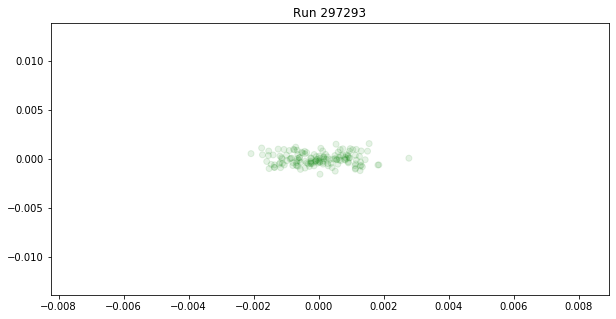

Good LS: 144 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144]
Bad LS: 0 []
Anomalies LS: 0 []
GOOD LS


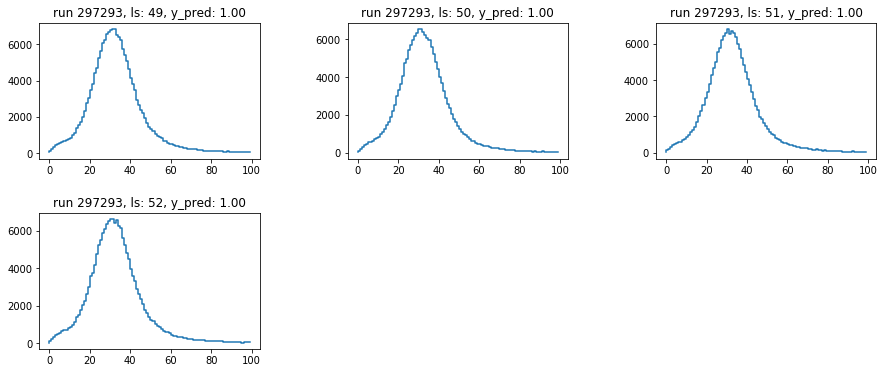

BAD LS
ANOMALOUS LS
Training set shape (10448, 121)
Explained variance ratio [0.90359182 0.07872154 0.00337199 0.00141811]


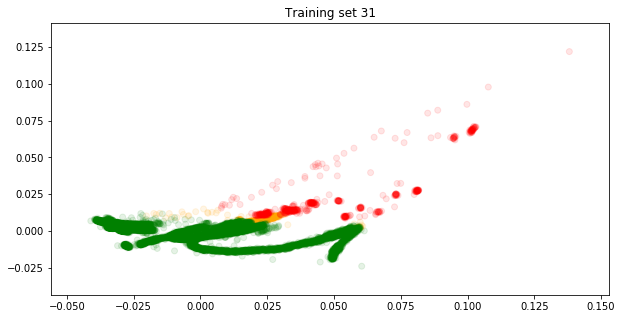

Training model
Epoch 00058: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2487]]

********************************************************************************
Classifying Run 297296

Explained variance ratio [0.6230785  0.18466088 0.02310609 0.01032666]


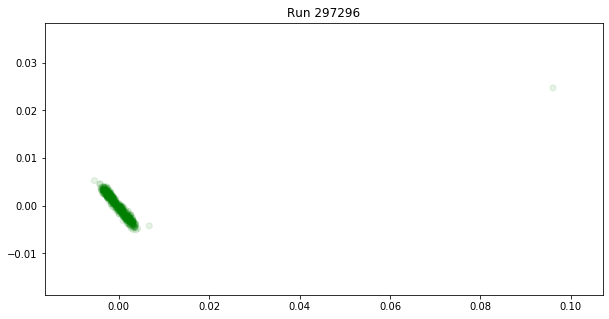

Good LS: 491 [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219,

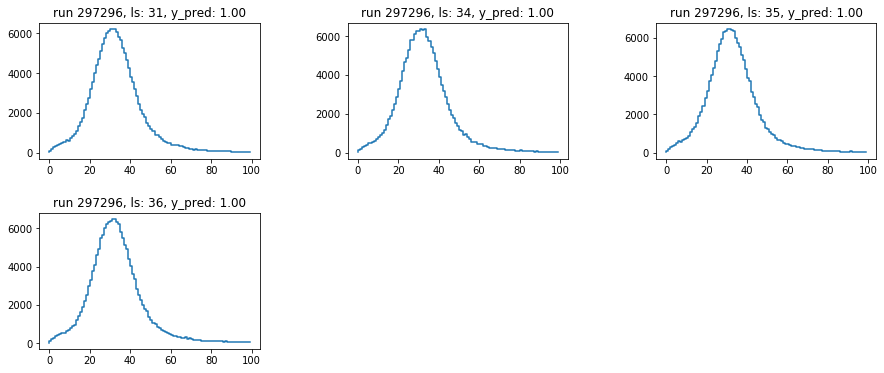

BAD LS
ANOMALOUS LS
Training set shape (10939, 121)
Explained variance ratio [0.89860722 0.0820237  0.00450968 0.00146813]


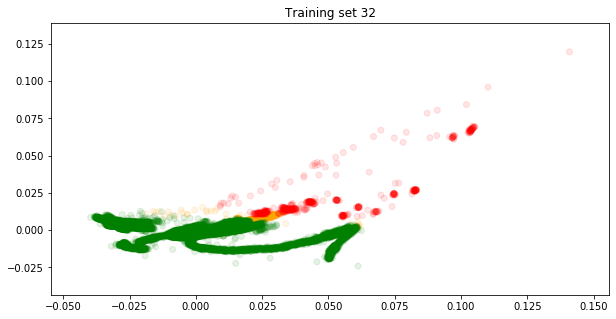

Training model
Epoch 00099: early stopping
Accuracy 1.0
[[ 125    0]
 [   0 2610]]

********************************************************************************
Classifying Run 297308

Explained variance ratio [0.89584088 0.02537327 0.01005656 0.00755411]


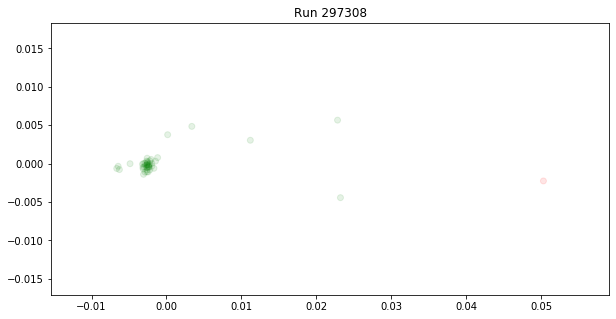

Good LS: 44 [1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45]
Bad LS: 1 [3]
Anomalies LS: 0 []
GOOD LS


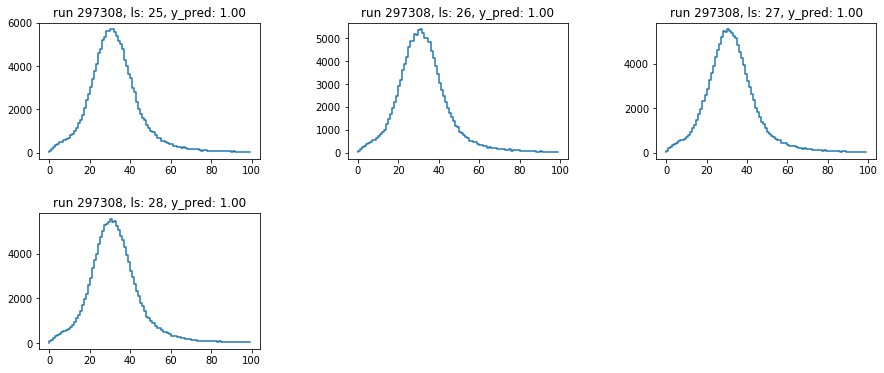

BAD LS


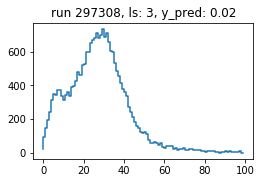

ANOMALOUS LS
Training set shape (10984, 121)
Explained variance ratio [0.8981412  0.08236854 0.00463212 0.00146517]


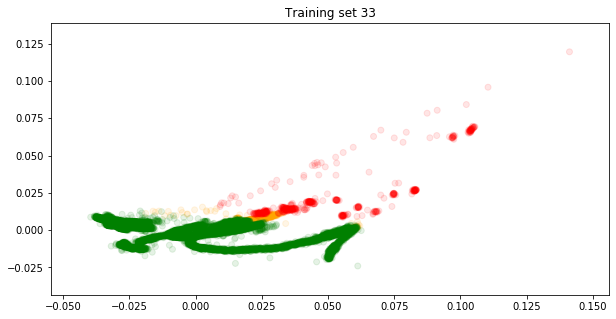

Training model
Epoch 00062: early stopping
Accuracy 1.0
[[ 126    0]
 [   0 2620]]

********************************************************************************
Classifying Run 297359

Explained variance ratio [0.85550884 0.10393722 0.00482706 0.00351026]


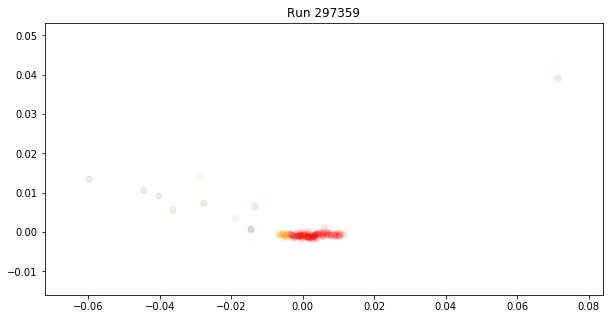

Good LS: 7 [39, 42, 43, 45, 178, 179, 180]
Bad LS: 116 [36, 41, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 159, 160]
Anomalies LS: 21 [40, 44, 158, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 181]
GOOD LS


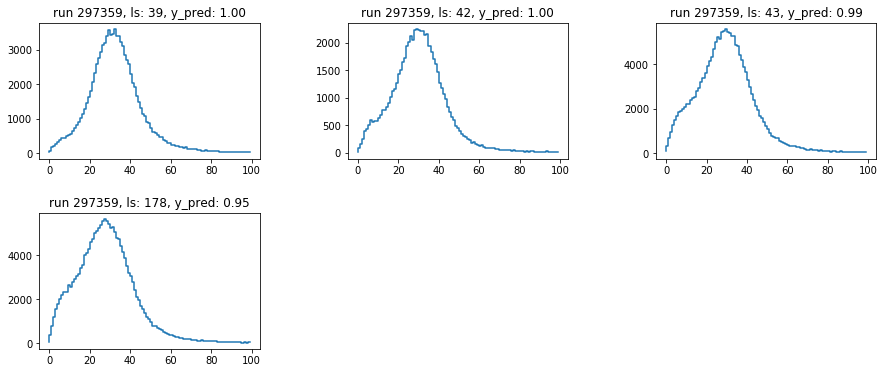

BAD LS


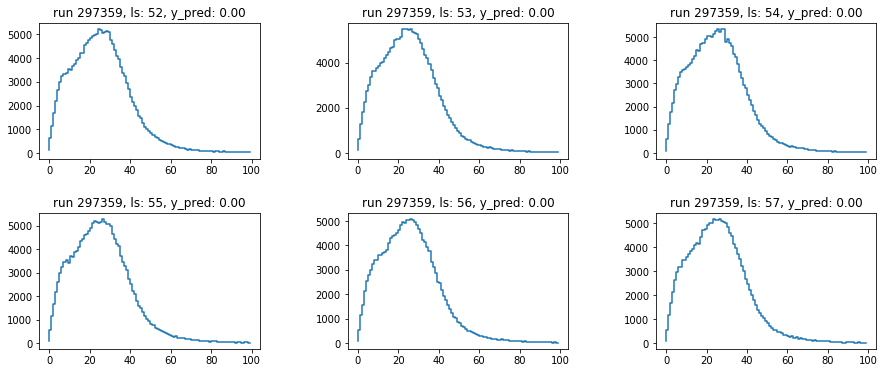

ANOMALOUS LS


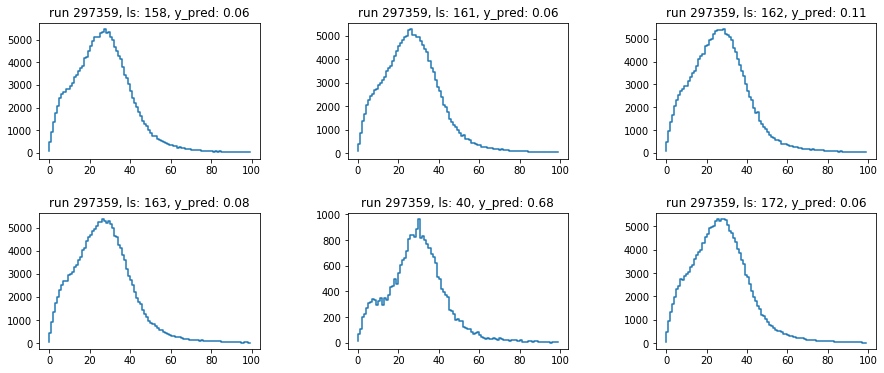

Training set shape (11107, 121)
Explained variance ratio [0.89749583 0.08309833 0.00466058 0.00144169]


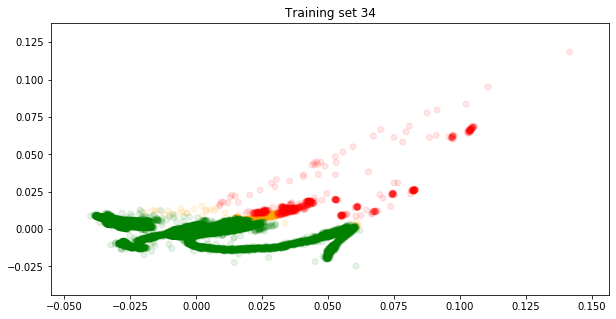

Training model
Epoch 00080: early stopping
Accuracy 1.0
[[ 155    0]
 [   0 2622]]

********************************************************************************
Classifying Run 297411

Explained variance ratio [0.94584489 0.00797465 0.00293892 0.00236459]


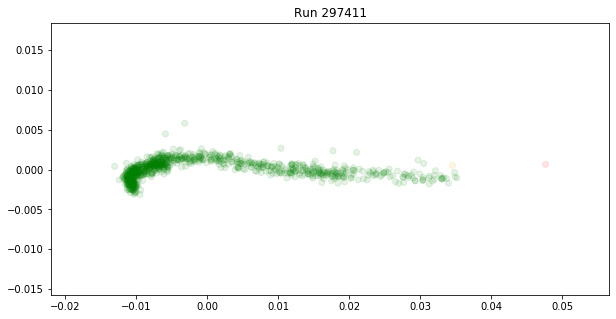

Good LS: 913 [34, 37, 38, 39, 40, 41, 42, 43, 44, 46, 47, 48, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186, 187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238, 239, 240, 241, 242, 243, 244, 245, 246, 247

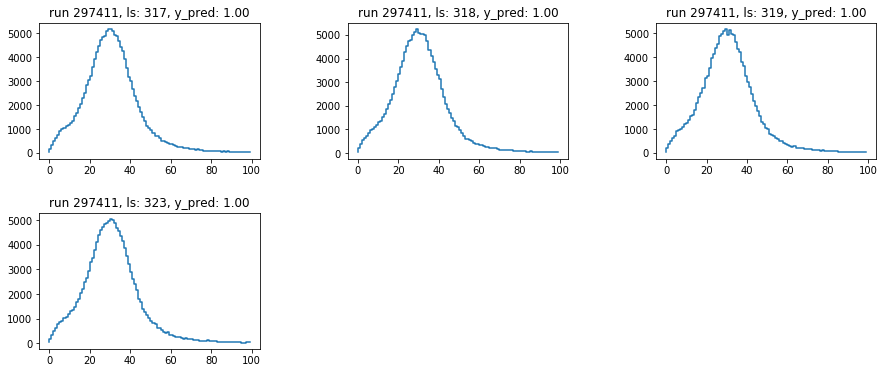

BAD LS


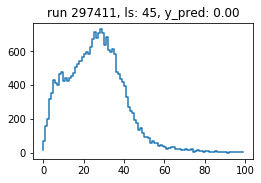

ANOMALOUS LS


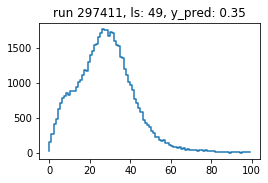

Training set shape (12021, 121)
Explained variance ratio [0.89228959 0.08731961 0.00546488 0.00142421]


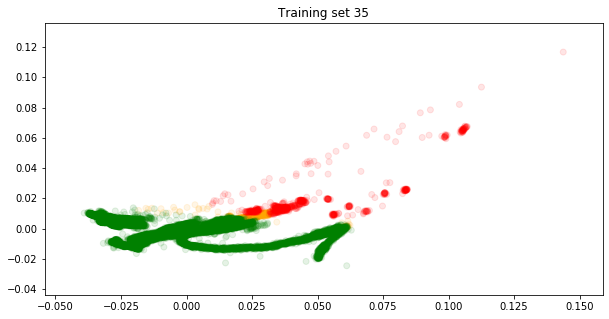

Training model


In [ ]:
model, df = self_train(df_train=df_train, df_test=df_test, run_numbers=run_numbers)

# View anomalies

In [ ]:
df_anomalies

In [ ]:
plt.figure(figsize=(20,10))

plt.title("Anomalies")

for index, row in df_anomalies.iterrows():

    data = [row[col]/row["entries"] for col in row.keys() if 'bin_' in col]
    data = data[1:-1]

    plt.plot(range(len(data)), data, alpha=.1)    
            
plt.show()

In [ ]:
view_lumisections(df_anomalies, 2, 45)

In [ ]:
model.save("{}/model.h5".format(target_dir))

In [ ]:
df_anomalies.to_csv("{}/df_anomalies.csv".format(target_dir))

In [ ]:
df.to_csv("{}/df.csv".format(target_dir))

In [ ]:
do_tsne(pd.concat([df, df_anomalies], ignore_index=True, sort=False))

In [ ]:
#convert -loop 0 `ls -v` ann_training.gif